
<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="100"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
</div>

## **TAREA 4: Análisis de Estimaciones de Pobreza Comunal en Chile - 2022**

**Autores:** Simón Ramirez - Victor Saldivia - Carlos Saquel  
**Asignatura:** Visualización de la Información

Este análisis tiene como objetivo explorar las estimaciones de pobreza por ingresos y pobreza multidimensional en las comunas de Chile durante el año 2022. Los datos fueron obtenidos a partir de los conjuntos de datos proporcionados por el [Ministerio de Desarrollo Social y Familia de Chile](https://observatorio.ministeriodesarrollosocial.gob.cl/pobreza-comunal-2022) a través del Ministerio de Desarrollo Social y Familia. Se presenta un análisis descriptivo y visualizaciones para comprender de mejor forma las correlaciones y características de la pobreza en las comunas del país.

### **IMPORTACIÓN DE LIBRERÍAS, CARGA Y LIMPIEZA DE DATOS**

In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.patches as patches
from matplotlib import lines
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.collections import PathCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import PercentFormatter, MultipleLocator
import matplotlib.gridspec as gridspec
import geopandas as gpd

from mpl_toolkits.axisartist.grid_finder import DictFormatter
import mpl_toolkits.axisartist.floating_axes as floating_axes

import matplotlib.font_manager as fm

import warnings
warnings.filterwarnings("ignore")

El archivo que vamos a utilizar contiene información sobre las estimaciones de pobreza en Chile para el año 2022, tanto de ingresos como multidimensional.
Comenzamos explorando los datos de estimación de pobreza por ingreso 2022.

In [2]:
df = pd.read_excel('./data/Estimaciones_Tasa_Pobreza_Ingresos_Comunas_2022.xlsx')
df.head(3)

Estimaciones de Tasa de Pobreza por ingresos por comuna. Aplicación de Metodologías de Estimación para Áreas Pequeñas (SAE) 2022  \
0                                                NaN                                                                                 
1                                             Código                                                                                 
2                                               1101                                                                                 

  Unnamed: 1     Unnamed: 2  \
0        NaN            NaN   
1     Región  Nombre comuna   
2   Tarapacá        Iquique   

                                          Unnamed: 3  \
0                                                NaN   
1  Número de personas según proyecciones de pobla...   
2                                             229674   

                                          Unnamed: 4  \
0                                                NaN   
1  Número de personas en situación de pobreza por...   
2                                              18122   

                                          Unnamed: 5               Unnamed: 6  \
0                                                NaN                      NaN   
1  Porcentaje de personas en situación de pobreza...  Límite inferior\n (***)   
2                                           0.078904                 0.064903   

        Unnamed: 7                                  Unnamed: 8  \
0              NaN                                         NaN   
1  Límite superior  Presencia de la comuna en la muestra Casen   
2         0.092905                                          Sí   

                          Unnamed: 9  
0                                NaN  
1    Tipo de estimación SAE \n(****)  
2  Directa y Sintética (Fay-Herriot)

En general, los datos están limpios, solo hay que comenzar eliminar la primara fila y renombrar las columnas para mejorar la legibilidad. 

In [3]:
# Funciones de limpieza de columnas y acentos
def accent_replace(col):
    reemplazos = {
        'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u',
        'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U',
    }
    for acento, sin_acento in reemplazos.items():
        col = col.replace(acento, sin_acento)
    return col

def columns_clean(columnas):
    columnas_limpias = []
    for col in columnas:
        col = accent_replace(col).lower().replace('\n', '')
        col = re.sub(r'\(.*?\)', '', col).replace('*', '').replace(' ', '_')
        col = re.sub(r'[^a-z0-9_]', '', col).rstrip('_')
        columnas_limpias.append(col)
    return columnas_limpias

def get_clean_data(file, get_rows):
    df = pd.read_excel(file, skiprows=get_rows[0])
    df = df.iloc[:get_rows[1]]
    df.columns = columns_clean(df.columns)
    return df

Al realizar una revisión de los datos tenemos 345 comunas con datos de:
- codigo: codigo numérico para cada comuna
- comuna: nombre de la comuna
- region:  región de la comuna
- poblacion: población de la comuna para el año 2022
- personas_pobreza_por_ingresos: multiplicación de la población por la estimación de pobreza por ingreso año 2022
- porcentaje_pobreza_por_ingresos_2022: estimación de pobreza por ingreso para el año 2022
- limite_inferior_ingreso: límite inferior del intervalo de confianza de la estimación de pobreza por ingreso 2022
- limite_superior_ingreso: límite superior del intervalo de confianza de la estimación de pobreza por ingreso 2022
- presencia_comuna_casen: indicativo de si la comna cuienta con encuesta case año 2022
- tipo_de_estimacion_sae: metodología de estimación de pobreza para áreas pequeñas (sae), Directa y Sintética (Fay-Herriot) o Sintética

In [4]:
df_1 = get_clean_data(file='./data/Estimaciones_Tasa_Pobreza_Ingresos_Comunas_2022.xlsx', get_rows=[2, 345])
df_1.columns = ['codigo', 'region', 'comuna', 'poblacion', 'personas_pobreza_por_ingresos', 'porcentaje_pobreza_por_ingresos_2022',
                'limite_inferior_ingreso', 'limite_superior_ingreso', 'presencia_comuna_casen', 'tipo_de_estimacion_sae']
df_1.head(3)

codigo    region         comuna  poblacion  personas_pobreza_por_ingresos  \
0   1101  Tarapacá        Iquique   229674.0                        18122.0   
1   1107  Tarapacá  Alto Hospicio   138527.0                        21144.0   
2   1401  Tarapacá   Pozo Almonte    18290.0                         2805.0   

   porcentaje_pobreza_por_ingresos_2022  limite_inferior_ingreso  \
0                              0.078904                 0.064903   
1                              0.152634                 0.137397   
2                              0.153344                 0.115596   

   limite_superior_ingreso presencia_comuna_casen  \
0                 0.092905                     Sí   
1                 0.167872                     Sí   
2                 0.191092                     Sí   

              tipo_de_estimacion_sae  
0  Directa y Sintética (Fay-Herriot)  
1  Directa y Sintética (Fay-Herriot)  
2  Directa y Sintética (Fay-Herriot)

In [5]:
df_1.describe(include='all')

codigo         region   comuna      poblacion  \
count    345.0            345      345     345.000000   
unique   345.0             16      345            NaN   
top     1101.0  Metropolitana  Iquique            NaN   
freq       1.0             52        1            NaN   
mean       NaN            NaN      NaN   57618.115942   
std        NaN            NaN      NaN   91321.953828   
min        NaN            NaN      NaN     207.000000   
25%        NaN            NaN      NaN    9959.000000   
50%        NaN            NaN      NaN   20525.000000   
75%        NaN            NaN      NaN   56542.000000   
max        NaN            NaN      NaN  661900.000000   

        personas_pobreza_por_ingresos  porcentaje_pobreza_por_ingresos_2022  \
count                      345.000000                            345.000000   
unique                            NaN                                   NaN   
top                               NaN                                   NaN   
freq                              NaN                                   NaN   
mean                      3748.527536                              0.090339   
std                       5168.776092                              0.043544   
min                          6.000000                              0.008747   
25%                        985.000000                              0.059865   
50%                       1863.000000                              0.085873   
75%                       3888.000000                              0.115698   
max                      33344.000000                              0.242779   

        limite_inferior_ingreso  limite_superior_ingreso  \
count                345.000000               345.000000   
unique                      NaN                      NaN   
top                         NaN                      NaN   
freq                        NaN                      NaN   
mean                   0.051886                 0.129155   
std                    0.034849                 0.054402   
min                    0.000000                 0.021982   
25%                    0.026897                 0.092199   
50%                    0.047585                 0.123562   
75%                    0.070589                 0.163677   
max                    0.191087                 0.319394   

       presencia_comuna_casen             tipo_de_estimacion_sae  
count                     345                                345  
unique                      2                                  2  
top                        Sí  Directa y Sintética (Fay-Herriot)  
freq                      335                                246  
mean                      NaN                                NaN  
std                       NaN                                NaN  
min                       NaN                                NaN  
25%                       NaN                                NaN  
50%                       NaN                                NaN  
75%                       NaN                                NaN  
max                       NaN                                NaN

In [6]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   codigo                                345 non-null    object 
 1   region                                345 non-null    object 
 2   comuna                                345 non-null    object 
 3   poblacion                             345 non-null    float64
 4   personas_pobreza_por_ingresos         345 non-null    float64
 5   porcentaje_pobreza_por_ingresos_2022  345 non-null    float64
 6   limite_inferior_ingreso               345 non-null    float64
 7   limite_superior_ingreso               345 non-null    float64
 8   presencia_comuna_casen                345 non-null    object 
 9   tipo_de_estimacion_sae                345 non-null    object 
dtypes: float64(5), object(5)
memory usage: 27.1+ KB


Ahora revisamos los datos de estimación de pobreza multidimensional 2022.

Los datos presentan las mismas 345 comunas con datos, agregando:
- personas_pobreza_multidimensional: multiplicación de la población por la estimación de pobreza multidimensional año 2022
- porcentaje_pobreza_multidimensional_2022: estimación de pobreza multidimensional para el año 2022
- limite_inferior_multidimensional: límite inferior del intervalo de confianza de la estimación de pobreza multidimensional 2022
- limite_superior_multidimensional: límite superior del intervalo de confianza de la estimación de pobreza multidimensional 2022

In [7]:
df_2 = get_clean_data(file='./data/Estimaciones_Indice_Pobreza_Multidimensional_Comunas_2022.xlsx', get_rows=[2, 345])
df_2.columns = ['codigo', 'region', 'comuna', 'poblacion', 'personas_pobreza_multidimensional', 'porcentaje_pobreza_multidimensional_2022',
                'limite_inferior_multidimensional', 'limite_superior_multidimensional', 'presencia_comuna_casen', 'tipo_de_estimacion_sae']
df_2.head(3)

codigo    region         comuna  poblacion  \
0   1101  Tarapacá        Iquique   229674.0   
1   1107  Tarapacá  Alto Hospicio   138527.0   
2   1401  Tarapacá   Pozo Almonte    18290.0   

   personas_pobreza_multidimensional  \
0                       41966.566241   
1                       45162.442981   
2                        4563.395313   

   porcentaje_pobreza_multidimensional_2022  limite_inferior_multidimensional  \
0                                  0.182722                          0.162429   
1                                  0.326019                          0.294776   
2                                  0.249502                          0.199334   

   limite_superior_multidimensional presencia_comuna_casen  \
0                          0.203015                     Sí   
1                          0.357263                     Sí   
2                          0.299671                     Sí   

              tipo_de_estimacion_sae  
0  Directa y Sintética (Fay-Herriot)  
1  Directa y Sintética (Fay-Herriot)  
2  Directa y Sintética (Fay-Herriot)

In [8]:
df_2.describe(include='all')

codigo         region   comuna      poblacion  \
count    345.0            345      345     345.000000   
unique   345.0             16      345            NaN   
top     1101.0  Metropolitana  Iquique            NaN   
freq       1.0             52        1            NaN   
mean       NaN            NaN      NaN   57618.115942   
std        NaN            NaN      NaN   91321.953828   
min        NaN            NaN      NaN     207.000000   
25%        NaN            NaN      NaN    9959.000000   
50%        NaN            NaN      NaN   20525.000000   
75%        NaN            NaN      NaN   56542.000000   
max        NaN            NaN      NaN  661900.000000   

        personas_pobreza_multidimensional  \
count                          345.000000   
unique                                NaN   
top                                   NaN   
freq                                  NaN   
mean                          9763.030150   
std                          15099.360264   
min                              0.234564   
25%                           2051.968205   
50%                           4087.274968   
75%                           9050.029870   
max                         125234.776994   

        porcentaje_pobreza_multidimensional_2022  \
count                                 345.000000   
unique                                       NaN   
top                                          NaN   
freq                                         NaN   
mean                                    0.194504   
std                                     0.070852   
min                                     0.001133   
25%                                     0.152218   
50%                                     0.188434   
75%                                     0.228287   
max                                     0.586389   

        limite_inferior_multidimensional  limite_superior_multidimensional  \
count                         345.000000                        345.000000   
unique                               NaN                               NaN   
top                                  NaN                               NaN   
freq                                 NaN                               NaN   
mean                            0.138041                          0.251170   
std                             0.060731                          0.083519   
min                             0.000000                          0.014602   
25%                             0.105272                          0.200601   
50%                             0.130985                          0.244170   
75%                             0.165782                          0.294340   
max                             0.434680                          0.738099   

       presencia_comuna_casen             tipo_de_estimacion_sae  
count                     345                                345  
unique                      2                                  2  
top                        Sí  Directa y Sintética (Fay-Herriot)  
freq                      335                                298  
mean                      NaN                                NaN  
std                       NaN                                NaN  
min                       NaN                                NaN  
25%                       NaN                                NaN  
50%                       NaN                                NaN  
75%                       NaN                                NaN  
max                       NaN                                NaN

In [9]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   codigo                                    345 non-null    object 
 1   region                                    345 non-null    object 
 2   comuna                                    345 non-null    object 
 3   poblacion                                 345 non-null    float64
 4   personas_pobreza_multidimensional         345 non-null    float64
 5   porcentaje_pobreza_multidimensional_2022  345 non-null    float64
 6   limite_inferior_multidimensional          345 non-null    float64
 7   limite_superior_multidimensional          345 non-null    float64
 8   presencia_comuna_casen                    345 non-null    object 
 9   tipo_de_estimacion_sae                    345 non-null    object 
dtypes: float64(5), object(5)
memory usage:

### **COMBINACIÓN DE DATASETS Y EXPLORACIÓN**

Ahora vamos a combinar estos 2 dataset para comenzar a explorar los datos

In [10]:
df_merge = df_1.merge(df_2[['codigo', 'porcentaje_pobreza_multidimensional_2022', 'limite_inferior_multidimensional', 'limite_superior_multidimensional']], on='codigo')
df_merge.head(3)

codigo    region         comuna  poblacion  personas_pobreza_por_ingresos  \
0   1101  Tarapacá        Iquique   229674.0                        18122.0   
1   1107  Tarapacá  Alto Hospicio   138527.0                        21144.0   
2   1401  Tarapacá   Pozo Almonte    18290.0                         2805.0   

   porcentaje_pobreza_por_ingresos_2022  limite_inferior_ingreso  \
0                              0.078904                 0.064903   
1                              0.152634                 0.137397   
2                              0.153344                 0.115596   

   limite_superior_ingreso presencia_comuna_casen  \
0                 0.092905                     Sí   
1                 0.167872                     Sí   
2                 0.191092                     Sí   

              tipo_de_estimacion_sae  \
0  Directa y Sintética (Fay-Herriot)   
1  Directa y Sintética (Fay-Herriot)   
2  Directa y Sintética (Fay-Herriot)   

   porcentaje_pobreza_multidimensional_2022  limite_inferior_multidimensional  \
0                                  0.182722                          0.162429   
1                                  0.326019                          0.294776   
2                                  0.249502                          0.199334   

   limite_superior_multidimensional  
0                          0.203015  
1                          0.357263  
2                          0.299671

#### **Visualización correlación a nivel general**

Se observan algunas correlaciones fuertes, en el caso de `poblacion` con `personas_pobreza_por_ingresos` la correlación no es interesante de revisar ya que una variable se calcula a partir de la otra.

Lo mismo en el caso de los rangos de los intervalos de confianza, ya que tanto los intervalos de confianza como la estimación de pobreza vienen del mismo cálculo y es razonable que tengan correlación alta.

En el caso de las estimaciones de pobreza, tanto por ingreso como multidimensional, presentan correlación medio en torno a `0.5`, puede ser interesante revisarlo. De momento lo dejamos pendiente para continuar con la exploración.

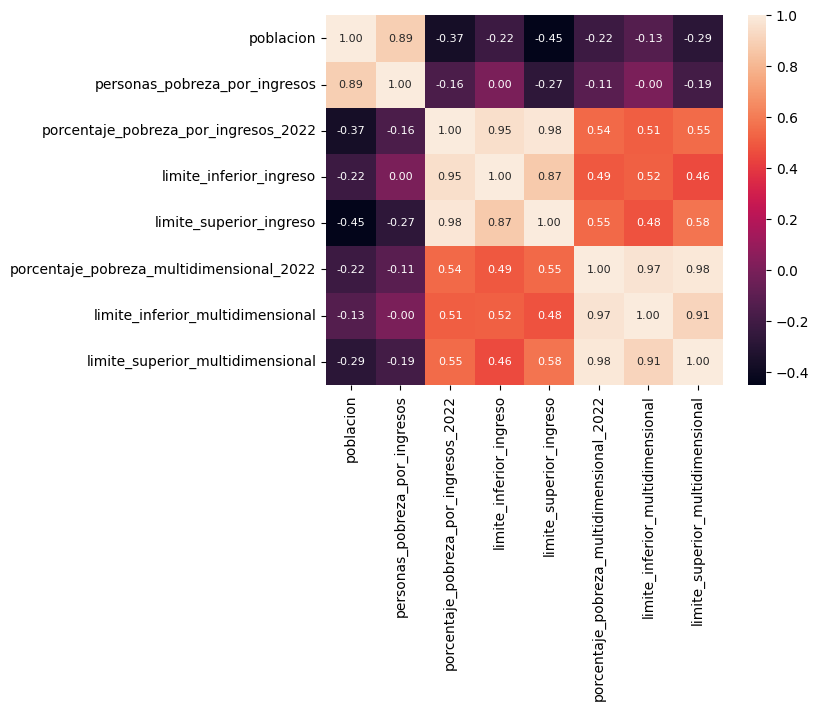

In [11]:
sns.heatmap(df_merge.corr(numeric_only=True), annot=True, fmt=".2f", annot_kws={"size": 8});

#### **Visualización de relaciones múltiples: Pairplot por región**

De momento, no se observa alguna relación tan clara. Si podría ser relevante la gran cantidad de población en la Región Metropolitana.

<Figure size 1000x1000 with 0 Axes>

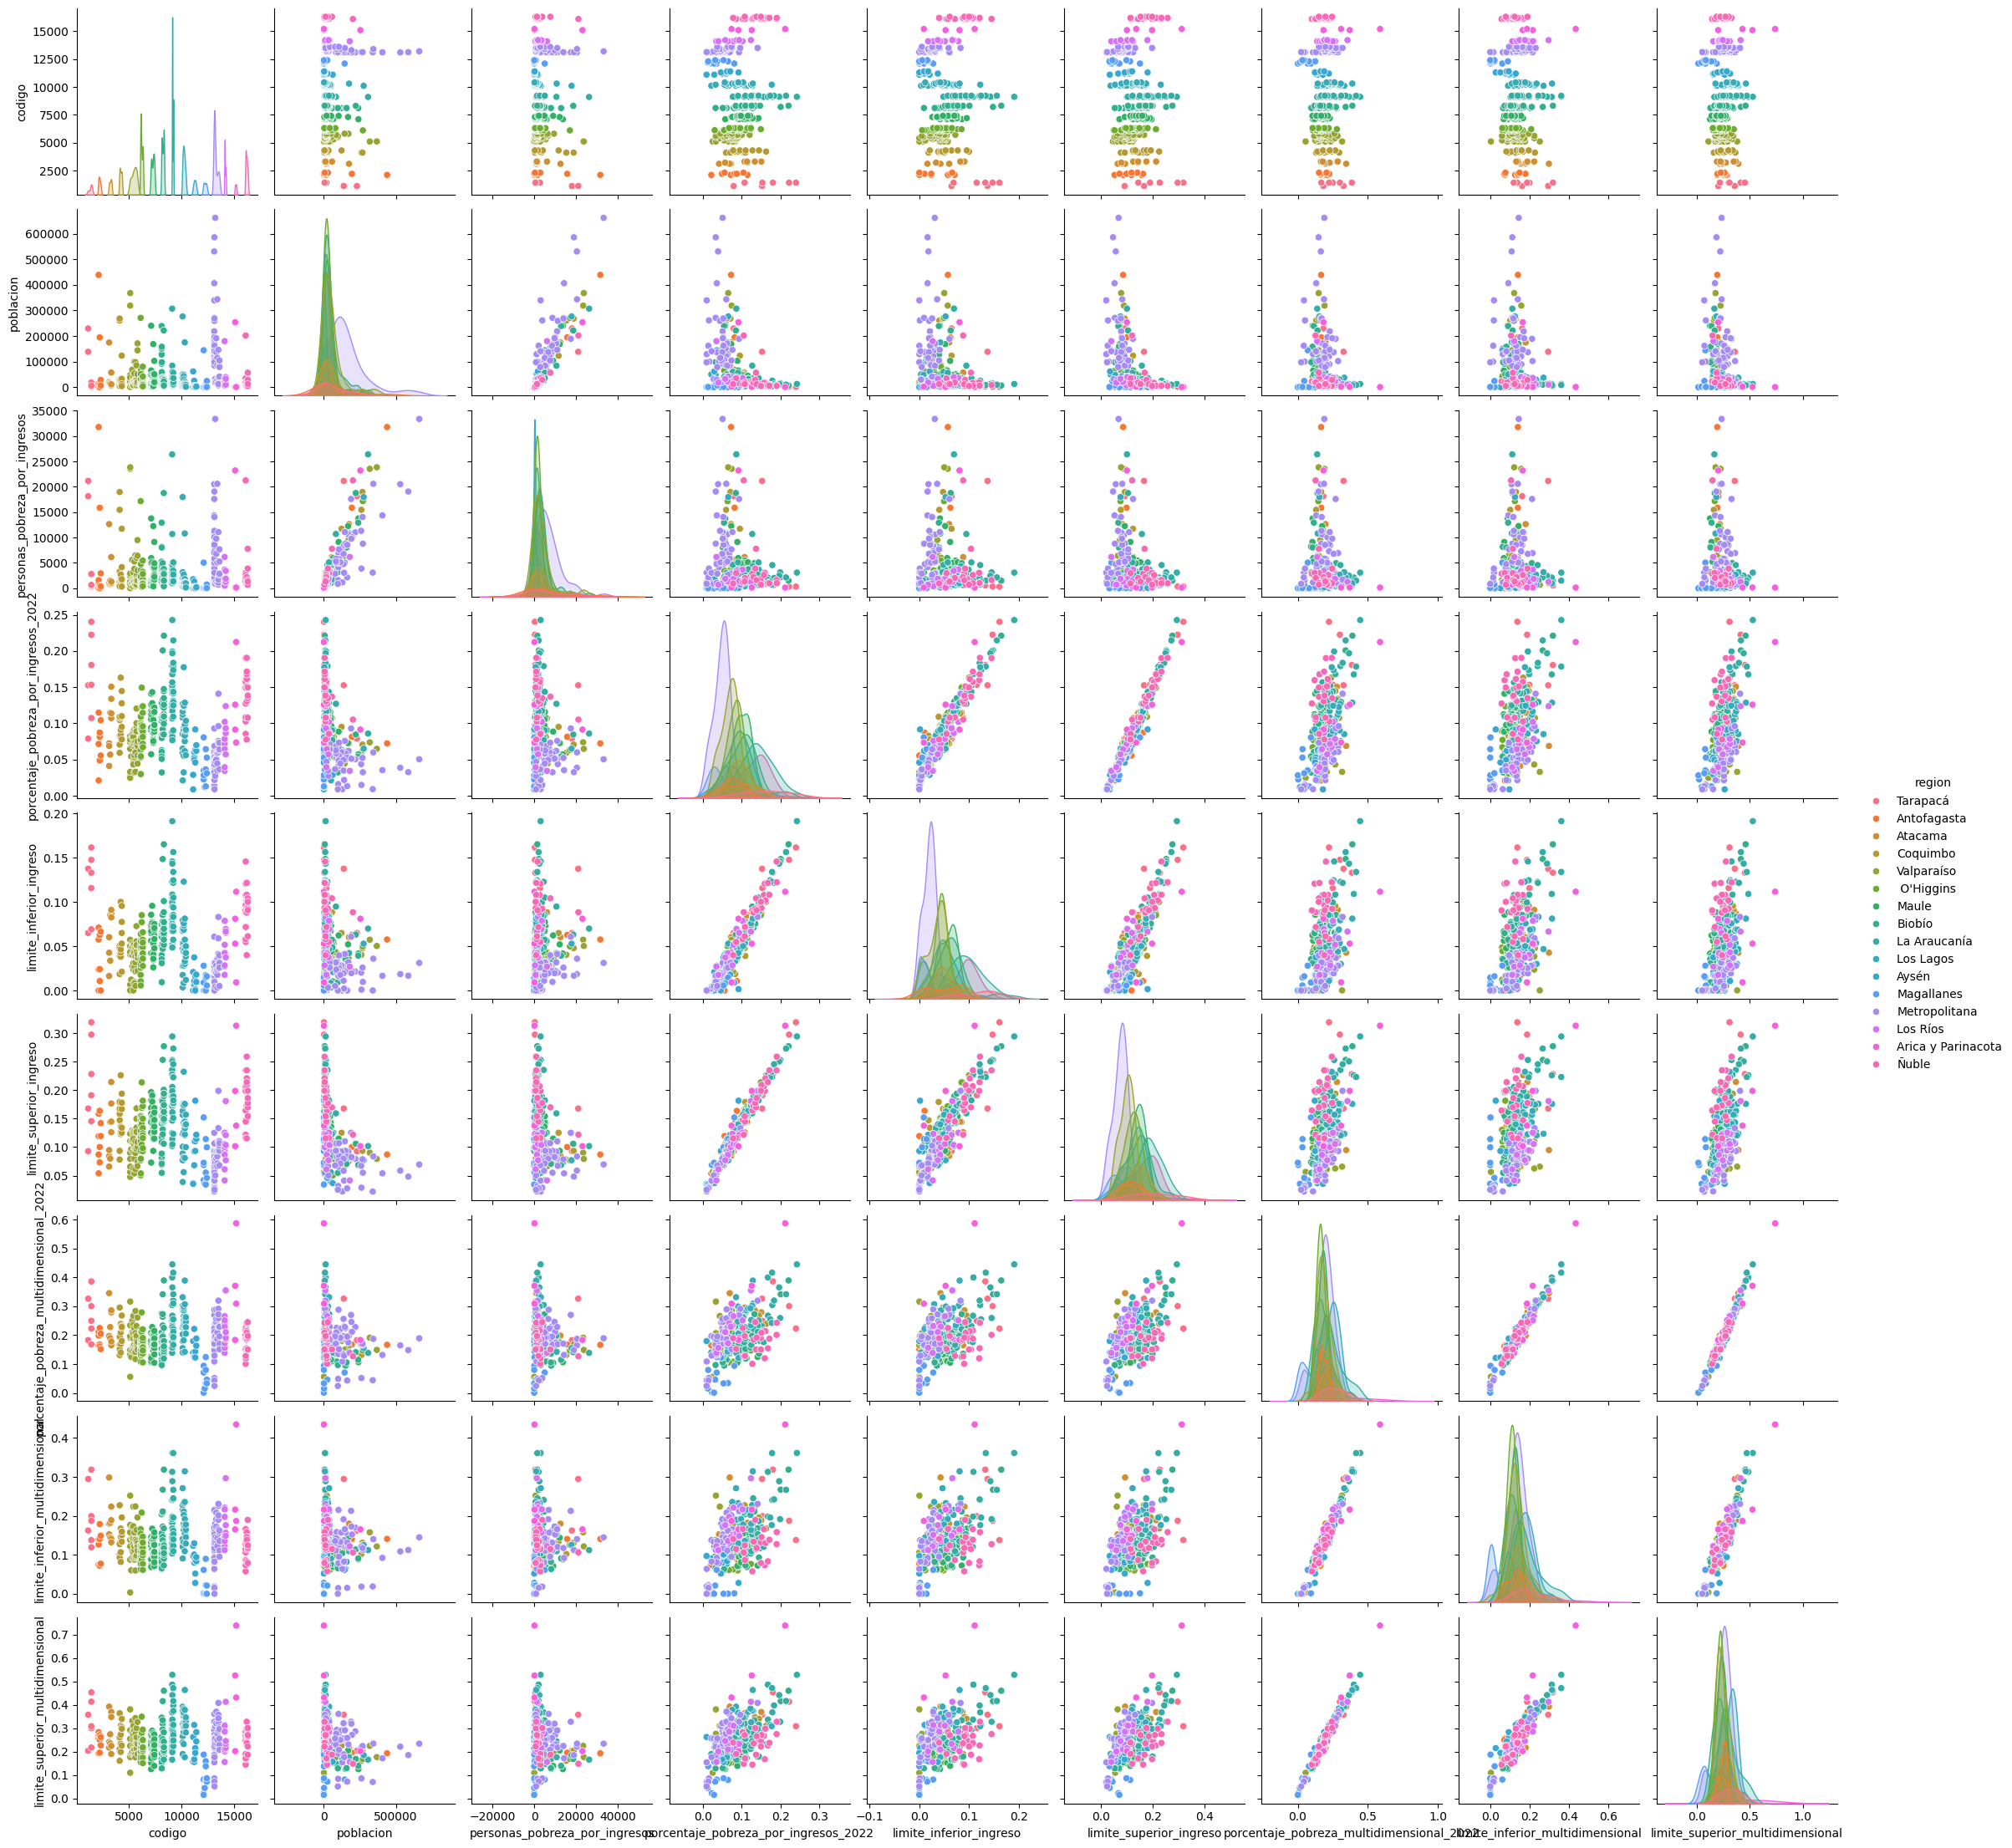

In [12]:
plt.figure(figsize=(10,10))
sns.pairplot(df_merge, hue='region');

#### Scatter Plot de Pobreza por Ingresos vs Pobreza Multidimensional, Segmentado por Región

Tomando lo anterior y revisando el scatterplot podría ser interesante revisar alguna relación entre la pobreza y la población, ya que la mayoría de las comunas en RM presentan un bajo porcentaje de pobreza comparado con el resto de regiones.

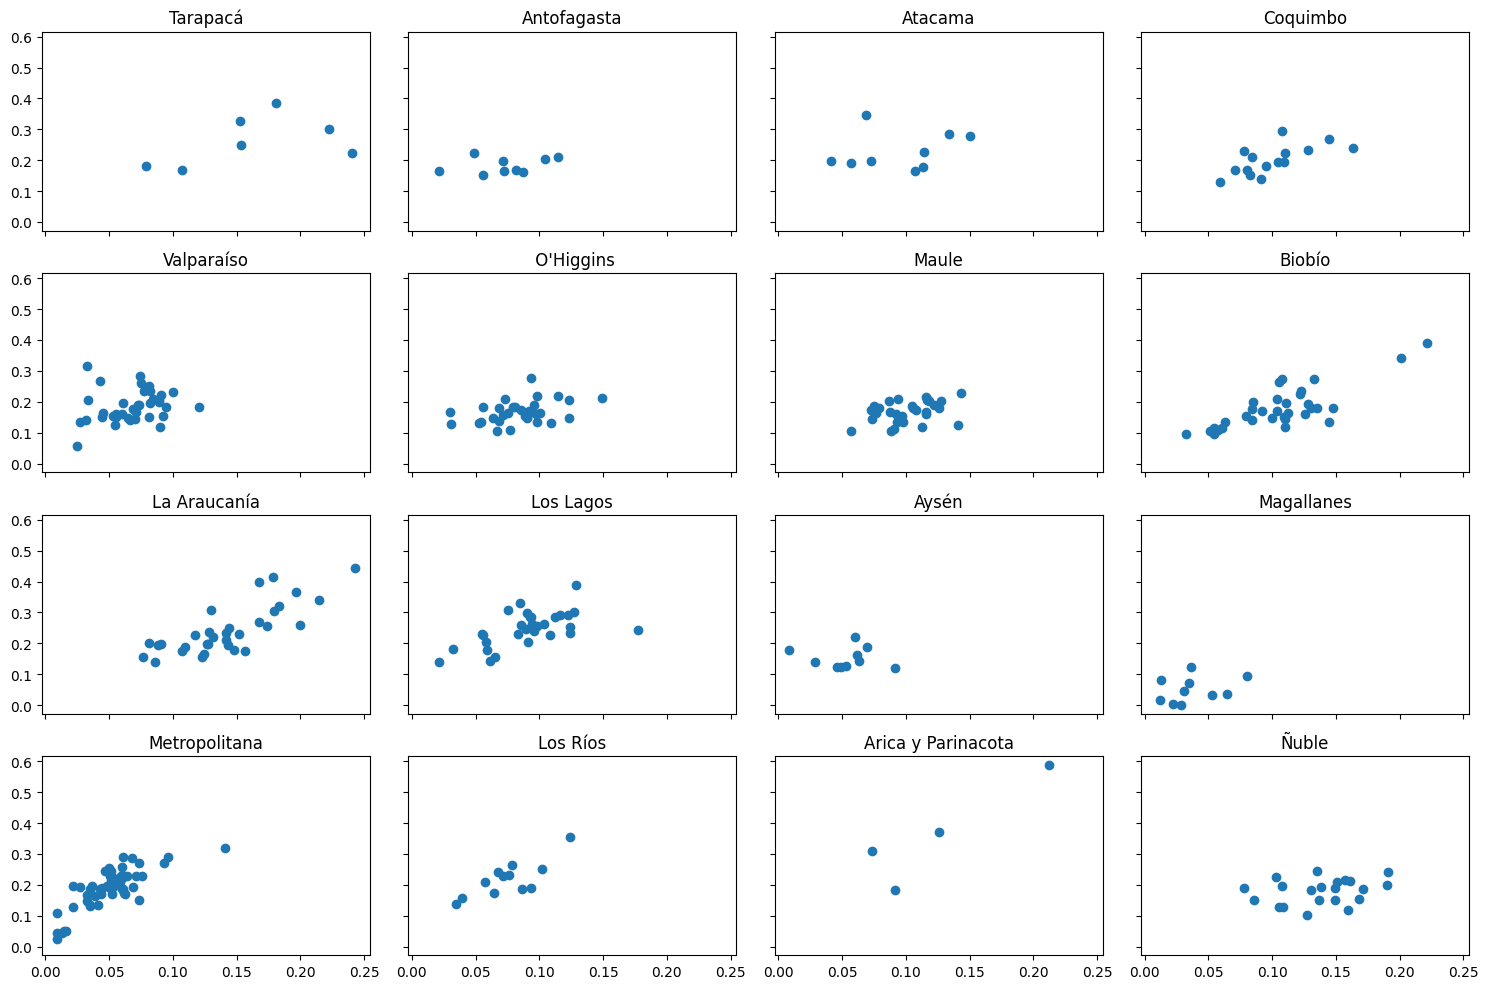

In [13]:
fig, ax = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True)
k=0
for i in range(4):
    for j in range(4):
        df_merge_region = df_merge[df_merge['region']==df_merge.region.unique()[k]]
        ax[i,j].scatter(x=df_merge_region['porcentaje_pobreza_por_ingresos_2022'], y=df_merge_region['porcentaje_pobreza_multidimensional_2022'])
        ax[i,j].set_title(df_merge.region.unique()[k])
        k+=1

plt.tight_layout()
plt.show()

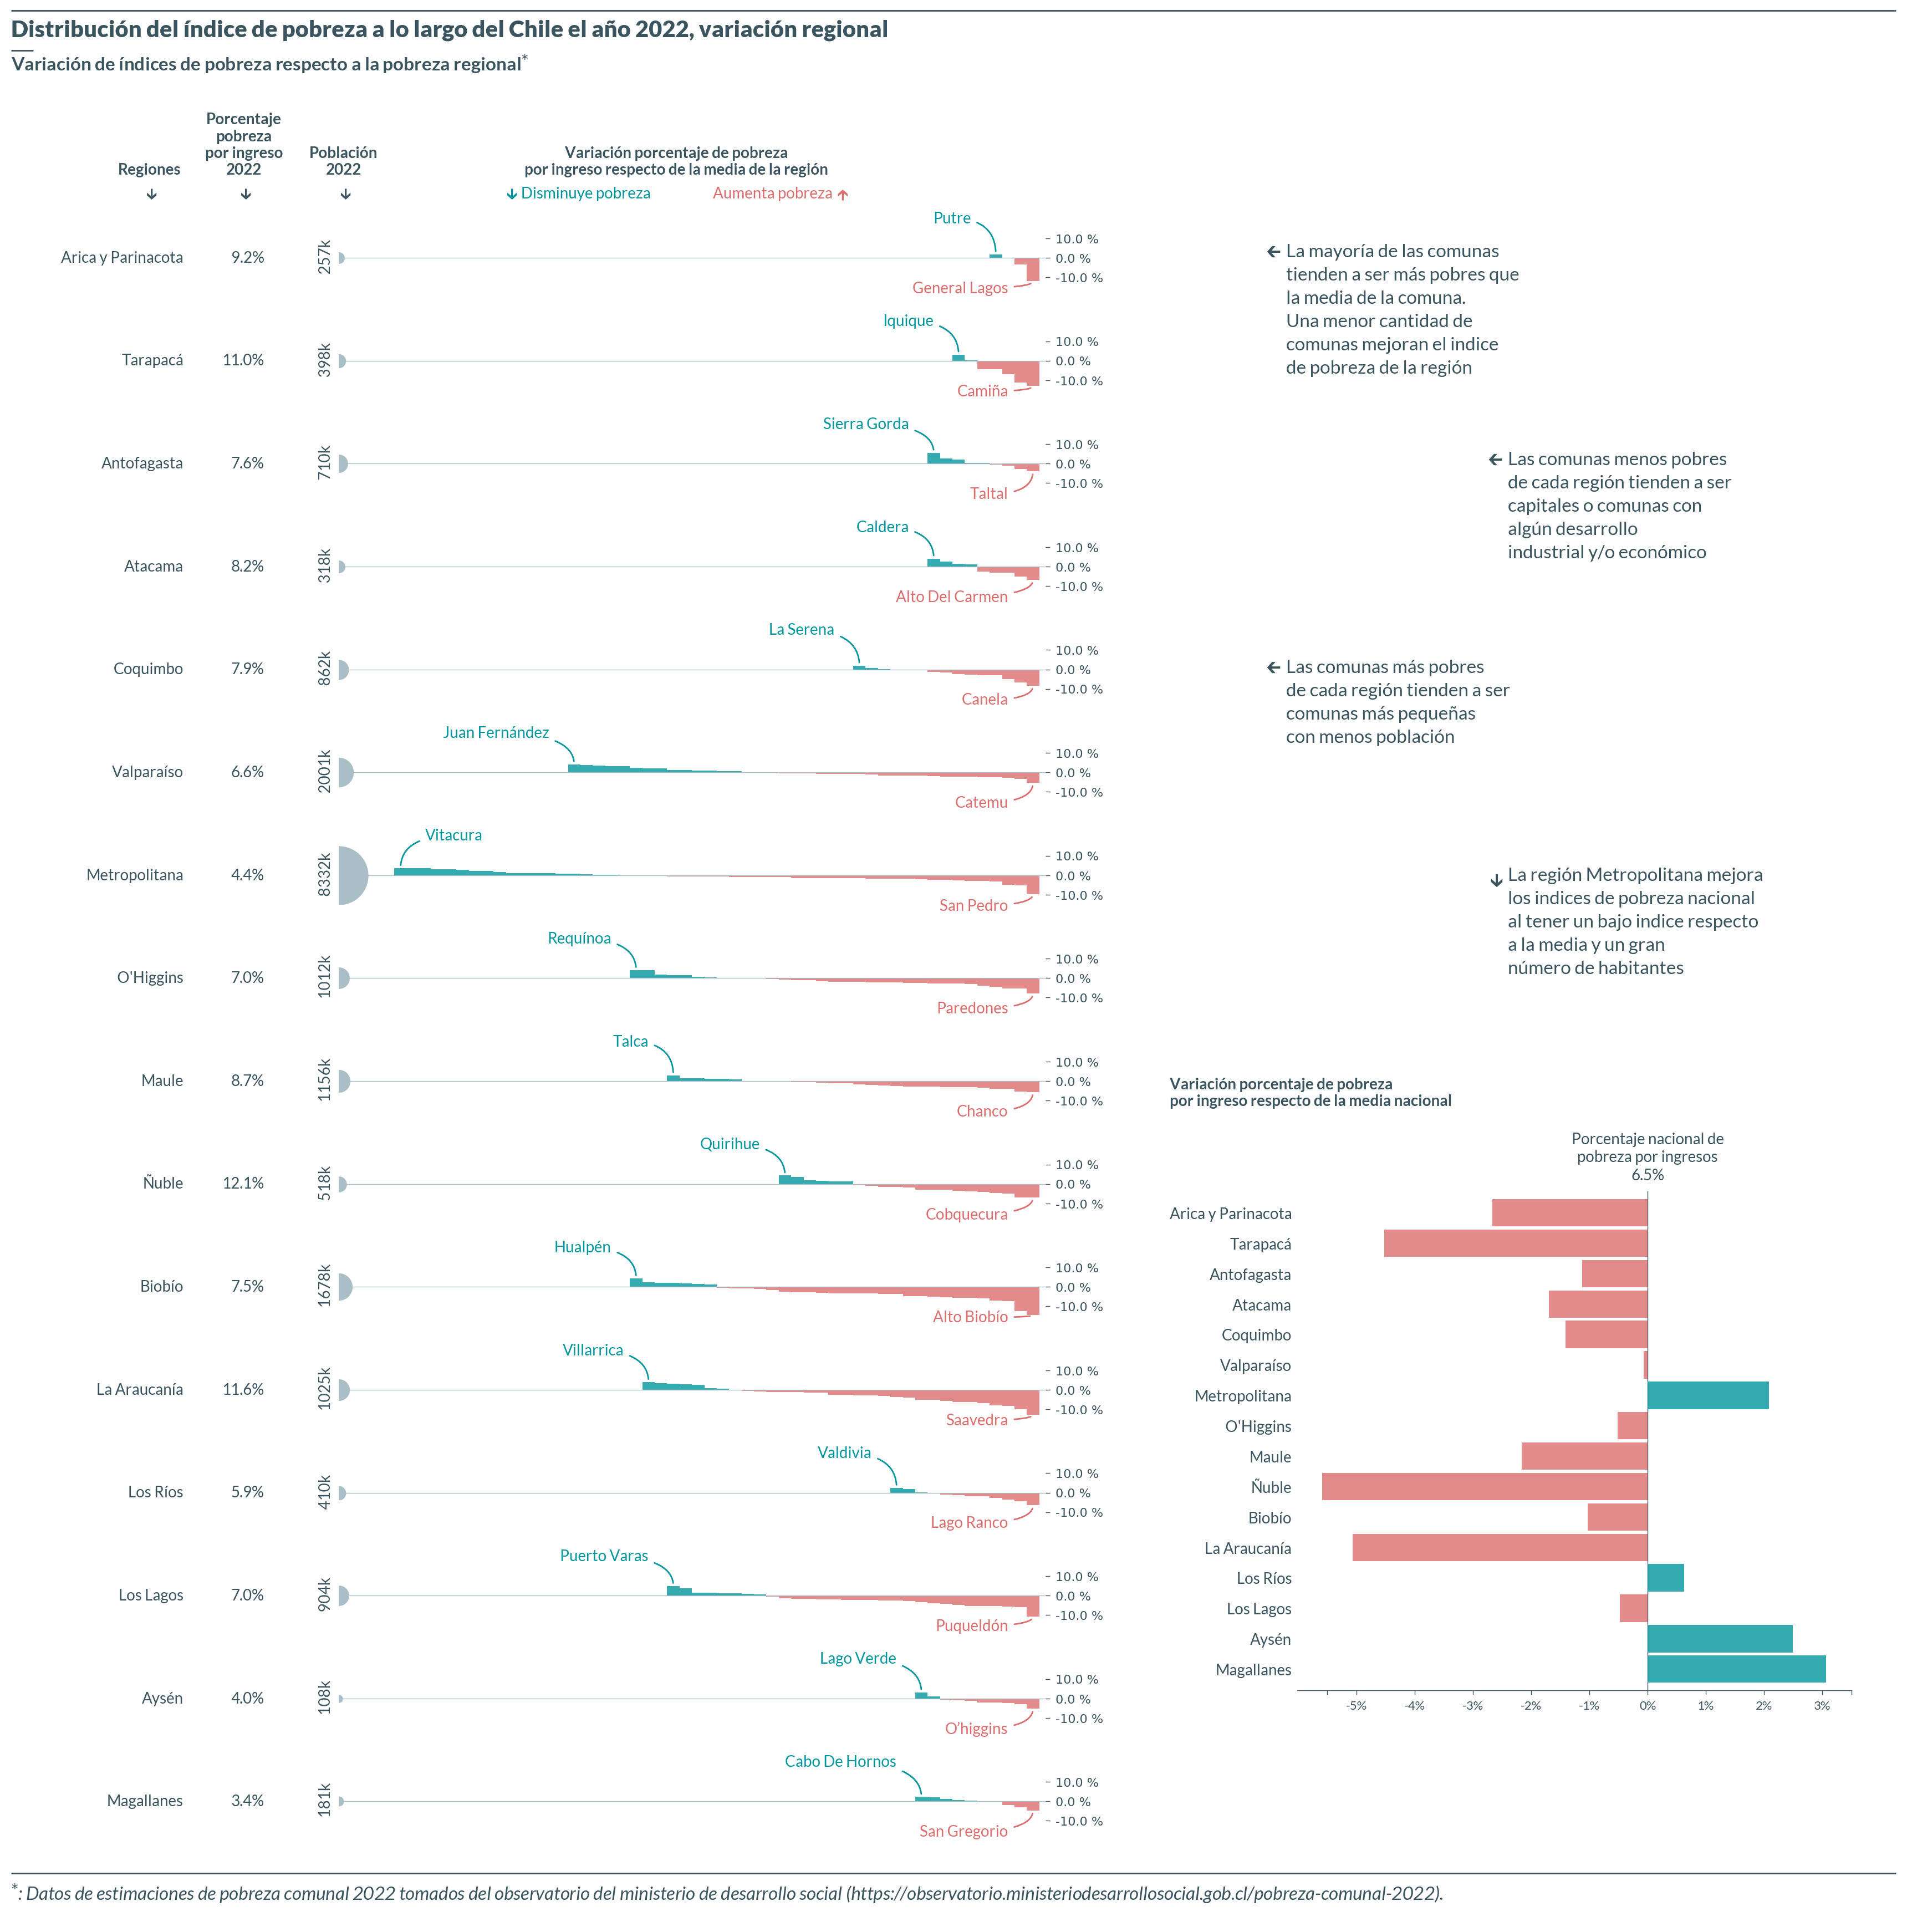

In [14]:
# Colores
############################################################################################
def mod_color_op(color, intensidad=1., alpha=1.):
    return (color[0] * intensidad, color[1] * intensidad, color[2] * intensidad, alpha)

col_yellow = (224,177,101,255)
col_green = (0,150,158,255)
col_salmon = (221,109,109,255)
col_wine = (155,97,128,255)
col_black = (3,2,8,255)
col_white = (225,232,234,255)
col_gray_text = (58,84,95,255)
col_gray = (170,190,199,255)
col_gray_dark = (108,135,147,255)

colorSalmon = tuple([i/255 for i in col_salmon])
colorYellow = tuple([i/255 for i in col_yellow])
colorYellow = mod_color_op(colorYellow, intensidad=0.93, alpha=1.)
colorGreen = tuple([i/255 for i in col_green])

colorBlack = tuple([i/255 for i in col_black])
colorWhite= tuple([i/255 for i in col_white])
colorGrayText = tuple([i/255 for i in col_gray_text])
colorGray = tuple([i/255 for i in col_gray])
colorGrayDark = tuple([i/255 for i in col_gray_dark])

color_region = {'Metropolitana': colorGreen, 'Valparaíso': colorSalmon, 'Biobío': colorYellow}


# Fuentes
############################################################################################
font_path_latoBlack = 'Lato/Lato-Black.ttf' 
font_path_latoB = 'Lato/Lato-Bold.ttf' 
font_path_latoR = 'Lato/Lato-Regular.ttf'
font_path_latoI = 'Lato/Lato-Italic.ttf'
font_path_noto2 = 'Noto_Sans_Symbols_2/NotoSansSymbols2-Regular.ttf'

prop_latoBlack = fm.FontProperties(fname=font_path_latoBlack)
prop_latoB = fm.FontProperties(fname=font_path_latoB)
prop_latoR = fm.FontProperties(fname=font_path_latoR)
prop_latoI = fm.FontProperties(fname=font_path_latoI)
prop_noto2 = fm.FontProperties(fname=font_path_noto2)

# Colores 
col_black = (3,2,8,255)
col_white = (225,232,234,255)
col_gray_text = (58,84,95,255)
col_gray = (170,190,199,255)
col_gray_dark = (108,135,147,255)

colorBlack = tuple([i/255 for i in col_black])
colorWhite= tuple([i/255 for i in col_white])
colorGrayText = tuple([i/255 for i in col_gray_text])
colorGray = tuple([i/255 for i in col_gray])
colorGrayDark = tuple([i/255 for i in col_gray_dark])

# Funciones
############################################################################################
def title1_fig(fig, posx_line_title, posy_line_title, color_text, color_line, text,
            lw_line_title, pos_x0_title, pos_y0_title, fontsize=14, fontproperties=prop_latoBlack, linespacing=1):
    fig.add_artist(
        lines.Line2D(posx_line_title, posy_line_title, lw=lw_line_title, 
                    color=color_line, solid_capstyle="butt", 
                    transform=fig.transFigure))
    fig.text(pos_x0_title, pos_y0_title, text,
            ha='left', va='top', fontsize=fontsize, weight=700, 
            color=color_text, fontproperties=fontproperties, linespacing=linespacing)

def error_bar_draw(fig, pos, df_merge):
    mean_pais = df_merge['personas_pobreza_por_ingresos'].sum() / df_merge['poblacion'].sum()
    region_x = {}
    for r in df_merge.sort_values('num_region', ascending=True)['region'].unique():
        mean_region = df_merge[df_merge['region']==r]['personas_pobreza_por_ingresos'].sum() / df_merge[df_merge['region']==r]['poblacion'].sum()
        region_x[r] = mean_pais - mean_region

    errorbar_ax = fig.add_axes(pos)
    errorbar_ax.barh(y=region_x.keys(), width=region_x.values(), height=0.9, color=[colorSalmon if k<0 else colorGreen for k in region_x.values()], alpha=0.8, zorder=2)
    errorbar_ax.spines['top'].set_visible(False)
    errorbar_ax.spines['right'].set_visible(False)
    errorbar_ax.spines['left'].set_visible(False)
    errorbar_ax.spines['bottom'].set_color(colorGrayText)
    errorbar_ax.spines['bottom'].set_linewidth(0.5)

    errorbar_ax.tick_params(axis='y', direction='out', length=0, width=0.5, colors=colorGrayText, grid_color=colorGray, grid_alpha=0)
    errorbar_ax.tick_params(axis='x', direction='out', length=3, width=0.5, colors=colorGrayText, grid_color=colorGray, grid_alpha=0)

    errorbar_ax.axvline(0, color=colorGrayText, linewidth=0.5, zorder=1)
    errorbar_ax.text(0,16,f"Porcentaje nacional de\npobreza por ingresos\n{np.round(mean_pais*100,1)}%", ha='center', va='bottom', 
            color=colorGrayText, fontproperties=prop_latoR, fontsize=10, linespacing=1.3)
    errorbar_ax.set_ylim([-0.7, 15.7])

    errorbar_ax.set_xticks([-0.055, -0.05, -0.04, -0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03, 0.035])
    errorbar_ax.set_xticklabels(["", "-5%", "-4%", "-3%", "-2%", "-1%", "0%", "1%", "2%", "3%", ""], color=colorGrayText, fontproperties=prop_latoR, fontsize=8)
    errorbar_ax.set_yticklabels(region_x.keys(), color=colorGrayText, fontproperties=prop_latoR, fontsize=10)

# Grafico
############################################################################################
regiones_sort = {'Arica y Parinacota': 1, 'Tarapacá': 2, 'Antofagasta': 3, 'Atacama': 4, 'Coquimbo': 5, 'Valparaíso': 6, 'Metropolitana': 7, " O'Higgins": 8, 
                'Maule': 9, 'Ñuble': 10, 'Biobío': 11, 'La Araucanía': 12, 'Los Ríos': 13, 'Los Lagos': 14, 'Aysén': 15, 'Magallanes': 16}

df_merge['num_region'] = [17-regiones_sort[r] for r in df_merge.region]

fig, ax = plt.subplots(df_merge['region'].unique().shape[0], figsize=(10,15), dpi=200)

comunas_region_max = df_merge.groupby('region')['comuna'].count().max()
i=0
for r in df_merge.sort_values('num_region', ascending=False)['region'].unique():
    mean_region = df_merge[df_merge['region']==r]['personas_pobreza_por_ingresos'].sum() / df_merge[df_merge['region']==r]['poblacion'].sum()
    comunas_region_x = mean_region - df_merge.sort_values('porcentaje_pobreza_por_ingresos_2022', ascending=True)[df_merge['region']==r]['porcentaje_pobreza_por_ingresos_2022'].values
    shape_comuna = comunas_region_x.shape
    comunas_region_x = np.pad(comunas_region_x, (comunas_region_max - len(comunas_region_x), 0), mode='constant', constant_values=0)
    ax[i].bar(height=comunas_region_x, x=[j for j in range(comunas_region_max)], width=1, alpha=0.8,
            color=[colorSalmon if k<0 else colorGreen for k in comunas_region_x], zorder=1)
    ax[i].axhline(0, color=colorGray, linewidth=0.5)
    ax[i].set_xticks([])
    ax[i].set_ylim(-0.15, 0.15)
    ax[i].set_yticks([-0.10, 0, 0.10])
    ax[i].set_yticklabels(["-10.0 %", "0.0 %", "10.0 %"], fontsize=8)
    ax[i].set_xlim(-5, comunas_region_max)
    ax[i].yaxis.tick_right()
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_linewidth(0)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)

    ax[i].annotate(df_merge[df_merge['region']==r].loc[df_merge[df_merge['region']==r]['porcentaje_pobreza_por_ingresos_2022'].idxmax()].comuna, 
            xy=(51, comunas_region_x[-1]), xycoords='data', xytext=(49, -0.18), ha='right', textcoords='data', fontsize=10, 
            color=colorSalmon, fontproperties=prop_latoR, arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=colorSalmon))

    if r=='Metropolitana':
        ax[i].annotate(df_merge[df_merge['region']==r].loc[df_merge[df_merge['region']==r]['porcentaje_pobreza_por_ingresos_2022'].idxmin()].comuna, 
                xy=(52 - shape_comuna[0], comunas_region_x[-shape_comuna[0]]), xycoords='data', xytext=(54 - shape_comuna[0], 0.18), ha='left', textcoords='data', fontsize=10, 
                color=colorGreen, fontproperties=prop_latoR, arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=colorGreen))
    else:
        ax[i].annotate(df_merge[df_merge['region']==r].loc[df_merge[df_merge['region']==r]['porcentaje_pobreza_por_ingresos_2022'].idxmin()].comuna, 
                xy=(52 - shape_comuna[0], comunas_region_x[-shape_comuna[0]]), xycoords='data', xytext=(50 - shape_comuna[0], 0.18), ha='right', textcoords='data', fontsize=10, 
                color=colorGreen, fontproperties=prop_latoR, arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=colorGreen))

    ax[i].tick_params(axis='y', direction='out', length=3, width=0.5, colors=colorGrayText, grid_color=colorGray, grid_alpha=0)
    pob_region = df_merge[df_merge['region']==r]['poblacion'].sum()

    ax[i].text(-17.5,0,f"{r}", ha='right', va='center', color=colorGrayText, fontproperties=prop_latoR, fontsize=10)
    ax[i].text(-11,0,f"{np.round(mean_region * 100, 1)}%", ha='right', va='center', color=colorGrayText, fontproperties=prop_latoR, fontsize=10)
    ax[i].scatter(-5,0, s=pob_region/6000, zorder=2, color=colorGray)
    ax[i].text(-6,0,f" {int(pob_region/1000)}k", ha='center', va='center', rotation=90, color=colorGrayText, fontproperties=prop_latoR, fontsize=10)
    i+=1

fig.text(0.125, 1.01,"Regiones", ha='center', va='bottom', color=colorGrayText, fontproperties=prop_latoB, fontsize=10)
fig.text(0.125, 1., "🡲", ha='center', va='center', fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_noto2, rotation=-90)

fig.text(0.21, 1.01,"Porcentaje\npobreza\npor ingreso\n2022", ha='center', va='bottom', color=colorGrayText, fontproperties=prop_latoB, fontsize=10)
fig.text(0.21, 1., "🡲", ha='center', va='center', fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_noto2, rotation=-90)

fig.text(0.30, 1.01,"Población\n2022", ha='center', va='bottom', color=colorGrayText, fontproperties=prop_latoB, fontsize=10)
fig.text(0.30, 1., "🡲", ha='center', va='center', fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_noto2, rotation=-90)

fig.text(0.6, 1.01,"Variación porcentaje de pobreza\npor ingreso respecto de la media de la región", ha='center', va='bottom', color=colorGrayText, fontproperties=prop_latoB, fontsize=10)
fig.text(0.45, 1., "🡲", ha='center', va='center', fontsize=10, weight=900, color=colorGreen, fontproperties=prop_noto2, rotation=-90)
fig.text(0.46, 1.,"Disminuye pobreza", ha='left', va='center', color=colorGreen, fontproperties=prop_latoR, fontsize=10)

fig.text(0.751, 1., "🡲", ha='center', va='center', fontsize=10, weight=900, color=colorSalmon, fontproperties=prop_noto2, rotation=90)
fig.text(0.741, 1.,"Aumenta pobreza", ha='right', va='center', color=colorSalmon, fontproperties=prop_latoR, fontsize=10)

fig.text(1.045, 0.45,"Variación porcentaje de pobreza\npor ingreso respecto de la media nacional", ha='left', va='bottom', color=colorGrayText, fontproperties=prop_latoB, fontsize=10)
error_bar_draw(fig, [1.16, 0.1, 0.5, 0.3], df_merge)

# Anotaciones
fig.text(1.15, 0.97, "La mayoría de las comunas\ntienden a ser más pobres que\nla media de la comuna. \nUna menor cantidad de\ncomunas mejoran el indice\nde pobreza de la región", ha='left', va='top', 
            fontsize=12, weight=900, color=colorGrayText, fontproperties=prop_latoR, rotation=0, linespacing=1.5)
fig.text(1.15, 0.97, "🡰 ", ha='right', va='top', 
            fontsize=12, weight=900, color=colorGrayText, fontproperties=prop_noto2, rotation=0, linespacing=1.5)

fig.text(1.35, 0.845, "Las comunas menos pobres\nde cada región tienden a ser\ncapitales o comunas con\nalgún desarrollo\nindustrial y/o económico", ha='left', va='top', 
            fontsize=12, weight=900, color=colorGrayText, fontproperties=prop_latoR, rotation=0, linespacing=1.5)
fig.text(1.35, 0.845, "🡰 ", ha='right', va='top', 
            fontsize=12, weight=900, color=colorGrayText, fontproperties=prop_noto2, rotation=0, linespacing=1.5)

fig.text(1.15, 0.72, "Las comunas más pobres\nde cada región tienden a ser\ncomunas más pequeñas\ncon menos población", ha='left', va='top', 
            fontsize=12, weight=900, color=colorGrayText, fontproperties=prop_latoR, rotation=0, linespacing=1.5)
fig.text(1.15, 0.72, "🡰 ", ha='right', va='top', 
            fontsize=12, weight=900, color=colorGrayText, fontproperties=prop_noto2, rotation=0, linespacing=1.5)

fig.text(1.35, 0.595, "La región Metropolitana mejora\nlos indices de pobreza nacional\nal tener un bajo indice respecto\na la media y un gran\nnúmero de habitantes", ha='left', va='top', 
            fontsize=12, weight=900, color=colorGrayText, fontproperties=prop_latoR, rotation=0, linespacing=1.5)
fig.text(1.35, 0.595, "🡰 ", ha='right', va='top', 
            fontsize=12, weight=900, color=colorGrayText, fontproperties=prop_noto2, rotation=90, linespacing=1.5)

# Titulo
posx_line_title = [0., 1.7]
posy_line_title = [1.1+0.01, 1.1+0.01]
lw_line_title = 1
pos_x0_title = 0.
pos_y0_title = 1.095+0.01
title1_fig(fig, posx_line_title, posy_line_title, colorGrayText, colorGrayText,
        "Distribución del índice de pobreza a lo largo del Chile el año 2022, variación regional",
        lw_line_title, pos_x0_title, pos_y0_title, fontsize=15, fontproperties=prop_latoBlack)

# Sub-Titulo
posx_line_title = [0., 0.02]
posy_line_title = [pos_y0_title - 0.019, pos_y0_title - 0.019]
lw_line_title = 1
pos_x0_title = 0.
pos_y0_title = pos_y0_title - 0.0202
title1_fig(fig, posx_line_title, posy_line_title, colorGrayText, colorGrayText,
        "Variación de índices de pobreza respecto a la pobreza regional$^{*}$",
        lw_line_title, pos_x0_title, pos_y0_title, fontsize=12, fontproperties=prop_latoB)

# Pie pagina
posx_line_title = [0., 1.7]
posy_line_title = [-0.01, -0.01]
lw_line_title = 1
pos_x0_title = 0.
pos_y0_title = -0.015
title1_fig(fig, posx_line_title, posy_line_title, colorGrayText, colorGrayText,
        "$^{*}$: Datos de estimaciones de pobreza comunal 2022 tomados del observatorio del ministerio de desarrollo social (https://observatorio.ministeriodesarrollosocial.gob.cl/pobreza-comunal-2022).\n",
        lw_line_title, pos_x0_title, pos_y0_title, fontsize=12, fontproperties=prop_latoI)

plt.tight_layout()

Sería interesante además revisar si hay alguna relación geográfica en la pobreza, para esto necesitamos traer la información de longitud y latitud.
En este data set viene la superficie, por lo que tabién agregaremos la densidad de población en el 2022.

In [15]:
# Info de + datyos comunales
# para revisar relaciones de densidad de poblacion, latitud y longitud
# estas ultimas estan corregidas repecto de santiago para ver si hay alguna relacion entre distancia a santiago
df_dist = pd.read_csv('https://raw.githubusercontent.com/altazor-1967/Comunas-de-Chile/refs/heads/master/Latitud%20-%20Longitud%20Chile.csv')
df_dist.columns = ['codigo', 'comuna', 'provincia', 'región', 'superficie', 'población', 'densidad', 'IDH 2005', 'latitud', 'longitud', 'latitud (Sexagesimal)', 'longitud (Sexagesimal)']
df_dist.superficie = df_dist.superficie.str.strip().str.replace(',','').astype(float)
df_merge_2 = df_merge.merge(df_dist, on='codigo')
df_merge_2['densidad_pob_2022'] = df_merge_2['poblacion'] / df_merge_2['superficie'].astype(float)
df_merge_2.head(3)

codigo    region       comuna_x  poblacion  personas_pobreza_por_ingresos  \
0   1101  Tarapacá        Iquique   229674.0                        18122.0   
1   1107  Tarapacá  Alto Hospicio   138527.0                        21144.0   
2   1401  Tarapacá   Pozo Almonte    18290.0                         2805.0   

   porcentaje_pobreza_por_ingresos_2022  limite_inferior_ingreso  \
0                              0.078904                 0.064903   
1                              0.152634                 0.137397   
2                              0.153344                 0.115596   

   limite_superior_ingreso presencia_comuna_casen  \
0                 0.092905                     Sí   
1                 0.167872                     Sí   
2                 0.191092                     Sí   

              tipo_de_estimacion_sae  ...     región  superficie  población  \
0  Directa y Sintética (Fay-Herriot)  ...   Tarapacá      2242.1   191,468    
1  Directa y Sintética (Fay-Herriot)  ...   Tarapacá       572.9   108,375    
2  Directa y Sintética (Fay-Herriot)  ...   Tarapacá     13765.8    15,711    

   densidad IDH 2005  latitud longitud  latitud (Sexagesimal)  \
0      85.4    0.766 -20.2439 -70.1389          -20°14' 38''    
1     189.2      NaN -20.2569 -70.0219         -20°15'  25''    
2      1.14    0.722 -20.2908 -69.6958          -20°17' 27''    

  longitud (Sexagesimal) densidad_pob_2022  
0          -70°8'  20''         102.437001  
1           -70°1' 19''         241.799616  
2          -69°41' 45''           1.328655  

[3 rows x 26 columns]

Al realizar nuevamente el pairplot por región a los datos combinados con la ubicación geográfica tenemos que las comunas con alta densidad poblacional muestran bajos índices de pobreza.

<Figure size 1000x1000 with 0 Axes>

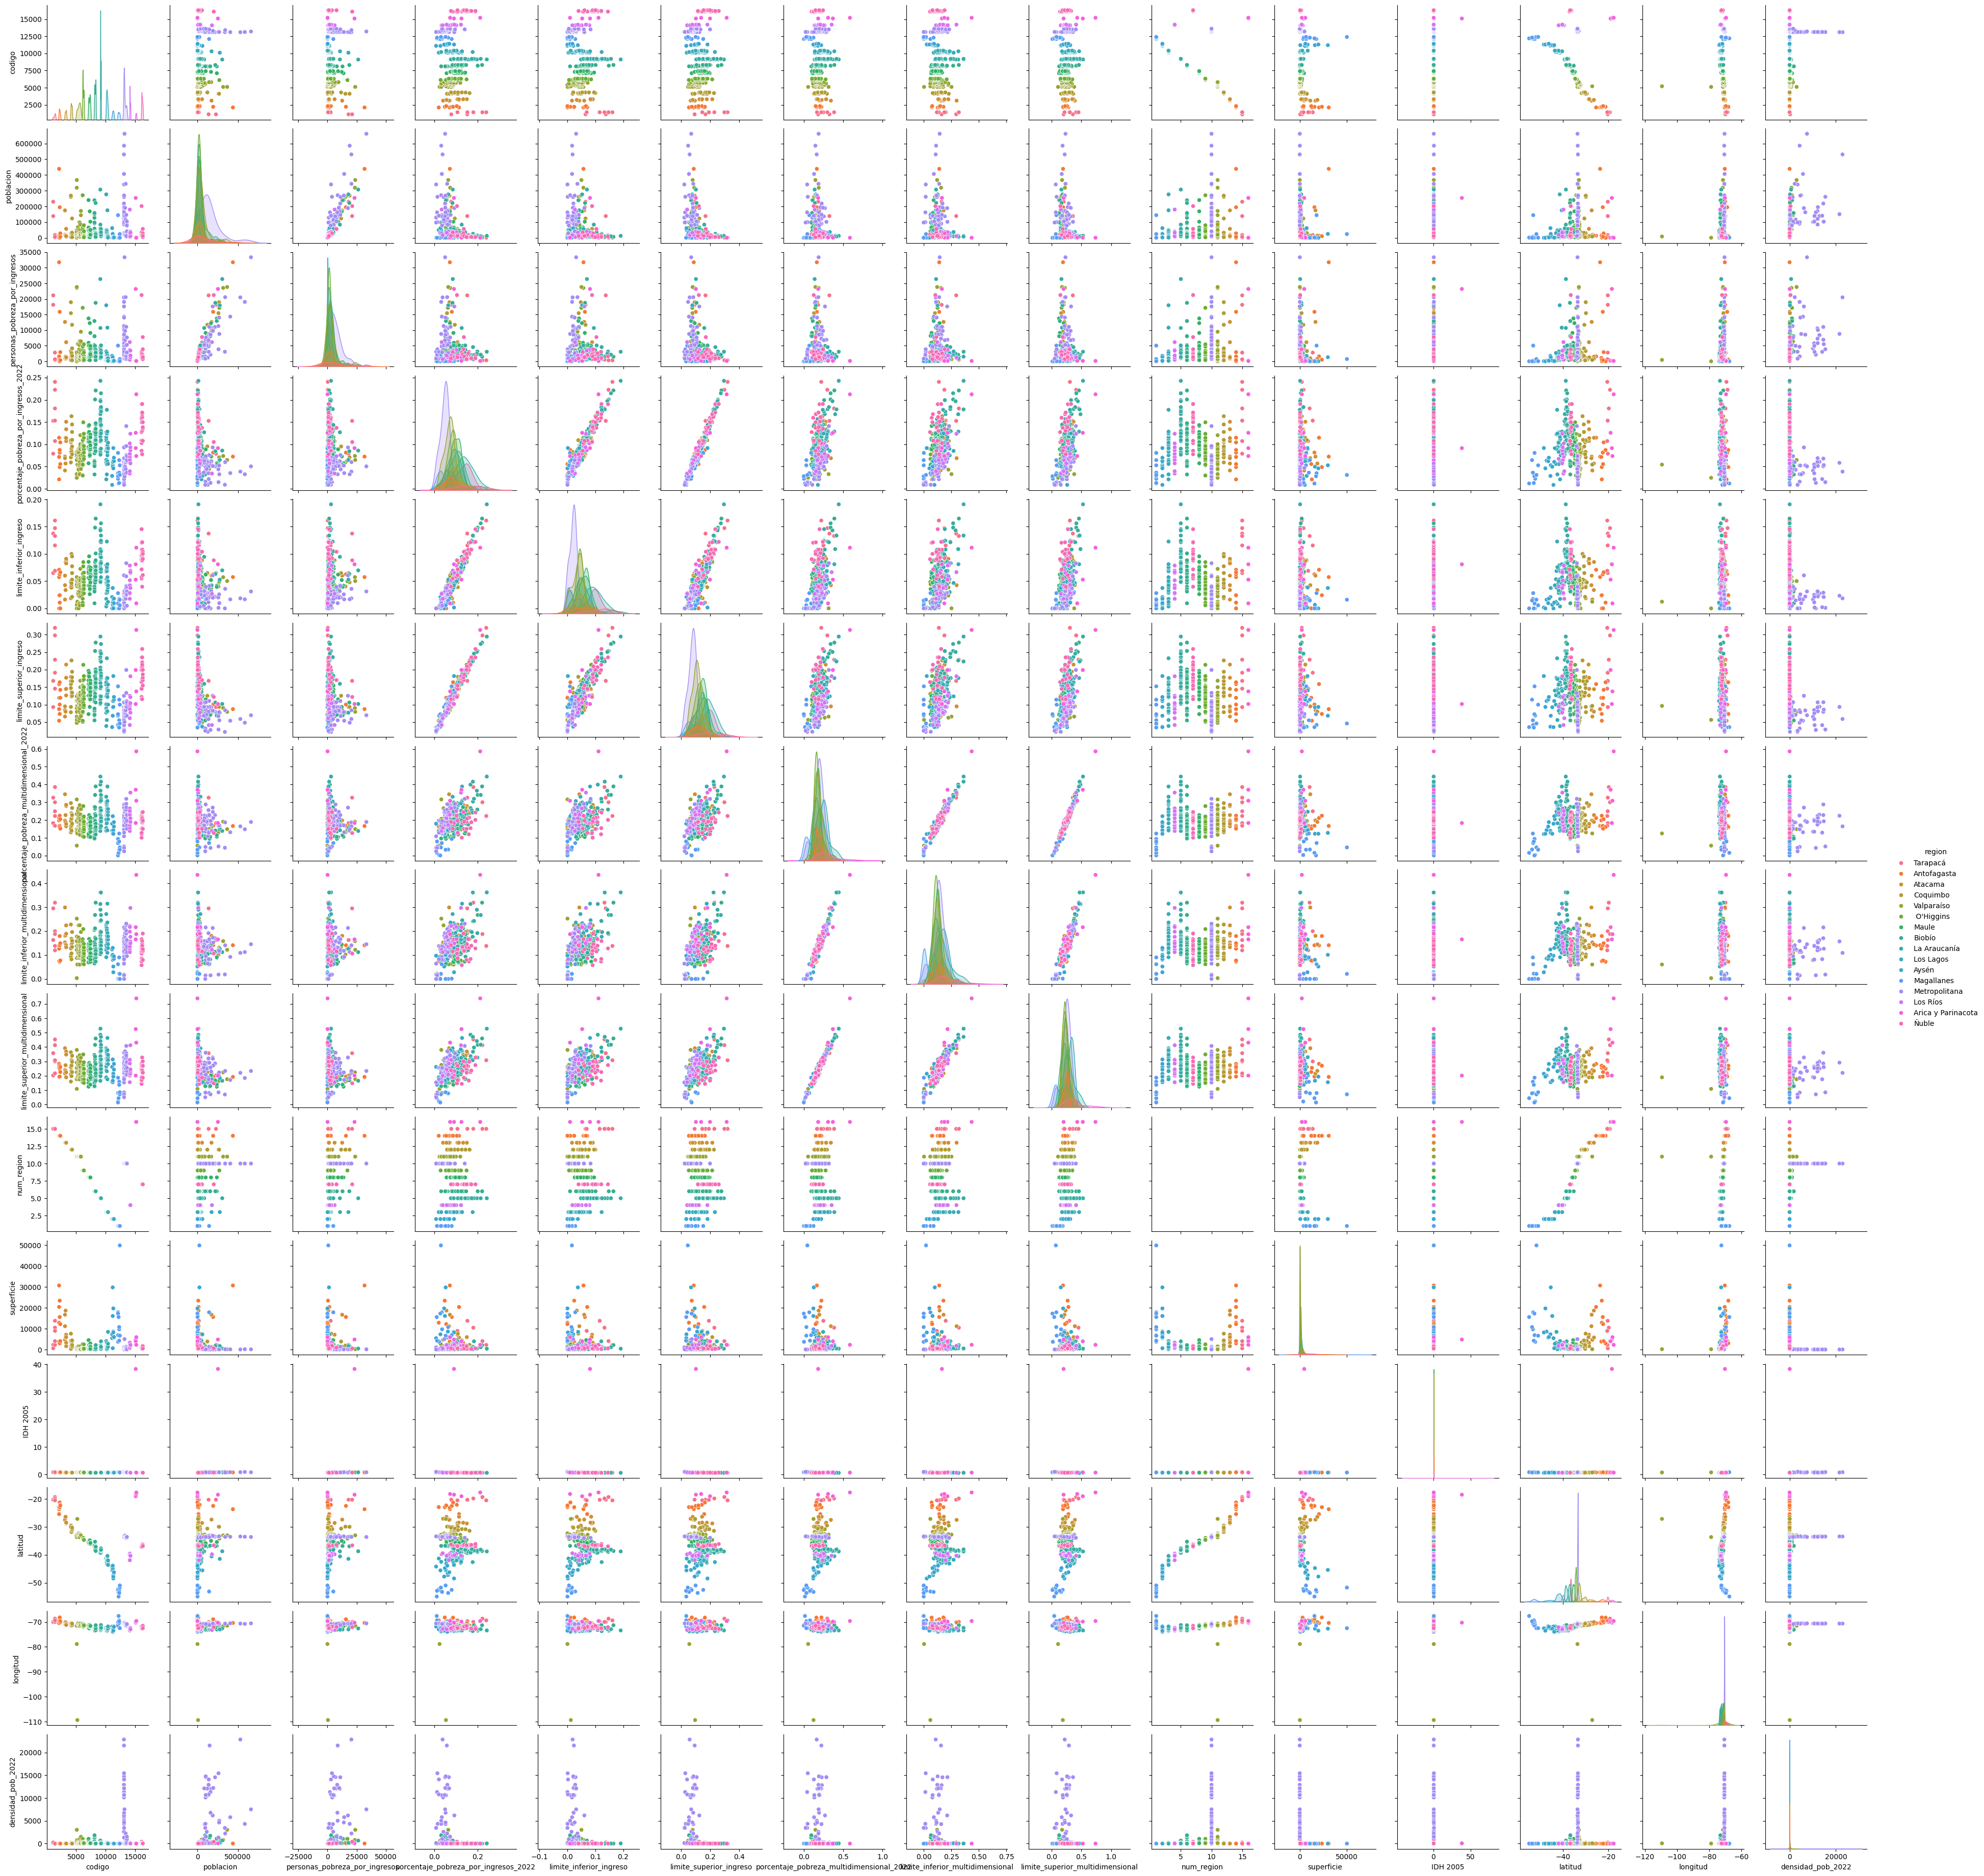

In [16]:
plt.figure(figsize=(10,10))
sns.pairplot(df_merge_2, hue='region');

Al hacer un zoom con un scatterplot entre la pobreza por ingreso vs la pobreza multidimensional tenemos una relación relativamente lineal entre estas 2 variables.
Lo más significativo es que al agregar el tamaño de los puntos como población y densidad de población se observa una clara relación entre una baja en índices de pobreza y estas 2 últimas variables.

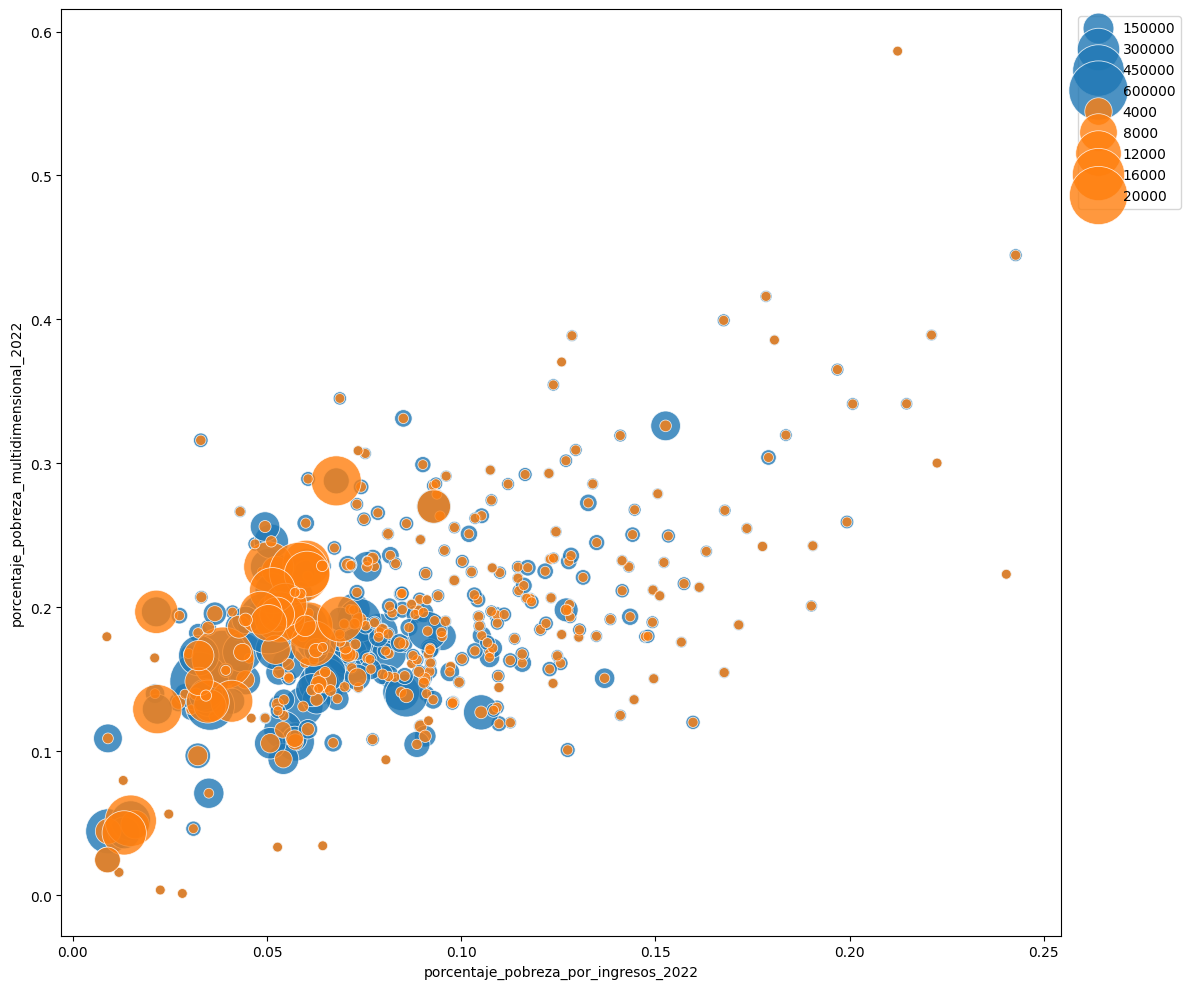

In [17]:
fig, ax = plt.subplots(1, figsize=(12,10))

sns.scatterplot(data=df_merge_2, x='porcentaje_pobreza_por_ingresos_2022', y='porcentaje_pobreza_multidimensional_2022', size='poblacion', sizes=(50, 2000), alpha=0.8, ax=ax)
sns.scatterplot(data=df_merge_2, x='porcentaje_pobreza_por_ingresos_2022', y='porcentaje_pobreza_multidimensional_2022', size='densidad_pob_2022', sizes=(50, 2000), alpha=0.8, ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
# Data para mapa de comunas
comunas = gpd.read_file('./Comunas/comunas.shp')
comunas = comunas.merge(df_merge_2, left_on='cod_comuna', right_on='codigo')

# Se seleccionan las 40 comunas más densas para no saturar el gráfico
comunas_top_densidad = df_merge_2[['region', 'comuna_x', 'poblacion', 'densidad_pob_2022', 'porcentaje_pobreza_por_ingresos_2022']]\
    .sort_values('densidad_pob_2022', ascending=False).head(40)[['region', 'comuna_x']]

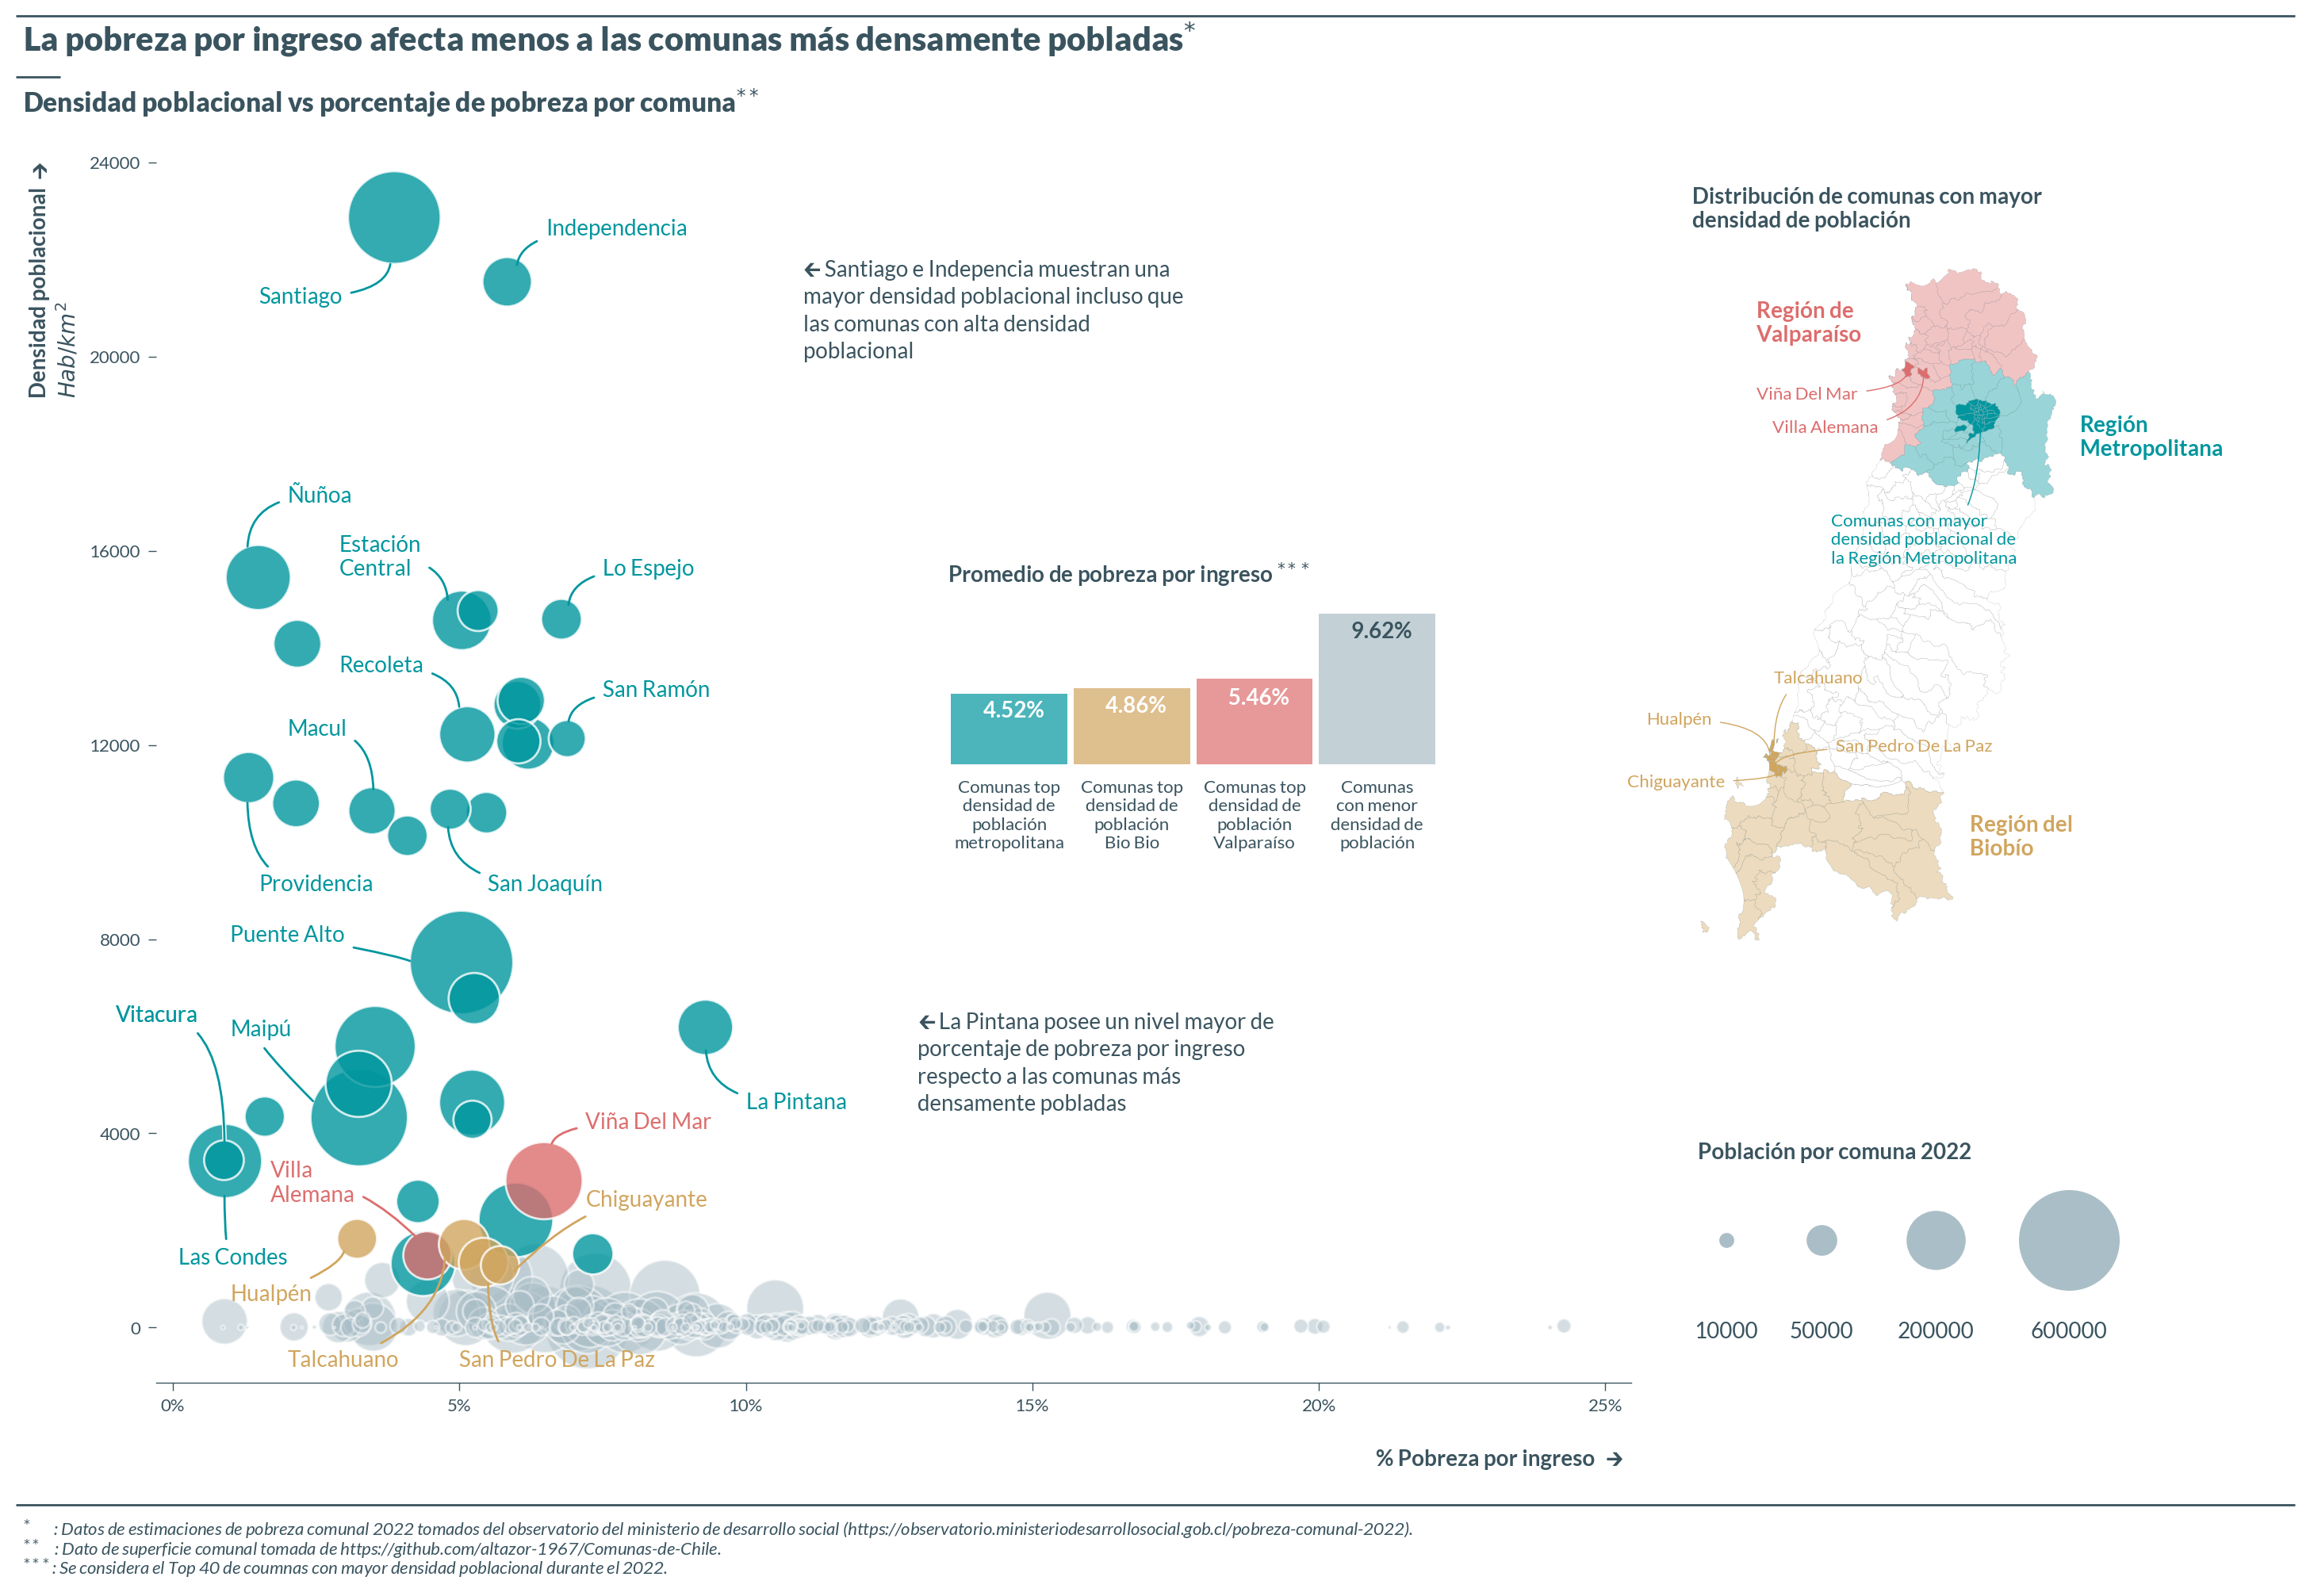

In [19]:
# Colores
############################################################################################
def mod_color_op(color, intensidad=1., alpha=1.):
    return (color[0] * intensidad, color[1] * intensidad, color[2] * intensidad, alpha)

col_yellow = (224,177,101,255)
col_green = (0,150,158,255)
col_salmon = (221,109,109,255)
col_wine = (155,97,128,255)
col_black = (3,2,8,255)
col_white = (225,232,234,255)
col_gray_text = (58,84,95,255)
col_gray = (170,190,199,255)
col_gray_dark = (108,135,147,255)

colorSalmon = tuple([i/255 for i in col_salmon])
colorYellow = tuple([i/255 for i in col_yellow])
colorYellow = mod_color_op(colorYellow, intensidad=0.93, alpha=1.)
colorGreen = tuple([i/255 for i in col_green])

colorBlack = tuple([i/255 for i in col_black])
colorWhite= tuple([i/255 for i in col_white])
colorGrayText = tuple([i/255 for i in col_gray_text])
colorGray = tuple([i/255 for i in col_gray])
colorGrayDark = tuple([i/255 for i in col_gray_dark])

color_region = {'Metropolitana': colorGreen, 'Valparaíso': colorSalmon, 'Biobío': colorYellow}


# Fuentes
############################################################################################
font_path_latoBlack = 'Lato/Lato-Black.ttf' 
font_path_latoB = 'Lato/Lato-Bold.ttf' 
font_path_latoR = 'Lato/Lato-Regular.ttf'
font_path_latoI = 'Lato/Lato-Italic.ttf'
font_path_noto2 = 'Noto_Sans_Symbols_2/NotoSansSymbols2-Regular.ttf'

prop_latoBlack = fm.FontProperties(fname=font_path_latoBlack)
prop_latoB = fm.FontProperties(fname=font_path_latoB)
prop_latoR = fm.FontProperties(fname=font_path_latoR)
prop_latoI = fm.FontProperties(fname=font_path_latoI)
prop_noto2 = fm.FontProperties(fname=font_path_noto2)

# Colores 
col_black = (3,2,8,255)
col_white = (225,232,234,255)
col_gray_text = (58,84,95,255)
col_gray = (170,190,199,255)
col_gray_dark = (108,135,147,255)

colorBlack = tuple([i/255 for i in col_black])
colorWhite= tuple([i/255 for i in col_white])
colorGrayText = tuple([i/255 for i in col_gray_text])
colorGray = tuple([i/255 for i in col_gray])
colorGrayDark = tuple([i/255 for i in col_gray_dark])


# Funciones
############################################################################################
def map_region_color_top_densidad(fig, pos, comunas, comunas_top_densidad, color_region, color_gray, alpha=0.2, xmin=-8.5*10**6, xmax=-7.5*10**6, ymin=-4.67*10**6, ymax=-3.75*10**6):
    map_color_ax = fig.add_axes(pos)

    regiones_sort = {'Arica y Parinacota': 1, 'Tarapacá': 2, 'Antofagasta': 3, 'Atacama': 4, 'Coquimbo': 5, 'Valparaíso': 6, 'Metropolitana': 7, " O'Higgins": 8, 
                    'Maule': 9, 'Ñuble': 10, 'Biobío': 11, 'La Araucanía': 12, 'Los Ríos': 13, 'Los Lagos': 14, 'Aysén': 15, 'Magallanes': 16}
    reg_min = comunas_top_densidad.region.apply(lambda x: regiones_sort[x]).min()
    reg_max = comunas_top_densidad.region.apply(lambda x: regiones_sort[x]).max()
    reg_range = [key for key, value in regiones_sort.items() if (value >= 6) & (value <= 11)]

    base = comunas[comunas.region.isin(reg_range)].plot(edgecolor='#555555', color='w',linewidth=0.1, ax=map_color_ax, alpha=0.4)
    for r in comunas_top_densidad.region.unique():
        comunas[(comunas['region']==r)].plot(edgecolor=color_gray, linewidth=0.1, ax=base, color=color_region[r], alpha=alpha)
        comuna_x_region = comunas_top_densidad[comunas_top_densidad.region==r].comuna_x
        comunas[(comunas['region']==r)&(comunas['comuna_x'].isin(comuna_x_region))].plot(edgecolor=color_gray, linewidth=0.1, ax=base, color=color_region[r])
    
    map_color_ax.text(xmin*0.91, ymax*1.07, f'Región\nMetropolitana', fontsize=10, fontproperties=prop_latoB, ha='left', color=color_region['Metropolitana'])
    map_color_ax.text(xmin*0.96, ymax*1.03, f'Región de\nValparaíso', fontsize=10, fontproperties=prop_latoB, ha='left', color=color_region['Valparaíso'])
    map_color_ax.text(xmin*0.927, ymax*1.21, f'Región del\nBiobío', fontsize=10, fontproperties=prop_latoB, ha='left', color=color_region['Biobío'])

    map_color_ax.text(xmin*0.97, ymax*0.99, 'Distribución de comunas con mayor\ndensidad de población', fontsize=10, fontproperties=prop_latoB, ha='left', color=colorGrayText)

    geom_vina = comunas[comunas.Comuna.str.contains('Viña')].geometry.centroid
    map_color_ax.annotate('Viña Del Mar', xy=(geom_vina.x, geom_vina.y), xycoords='data', 
            xytext=(geom_vina.x*1.025, geom_vina.y*1.01), textcoords='data', fontsize=8, color=color_region['Valparaíso'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Valparaíso'], linewidth=0.5))

    geom_v_alemana = comunas[comunas.Comuna.str.contains('Villa Alemana')].geometry.centroid
    map_color_ax.annotate('Villa Alemana', xy=(geom_v_alemana.x, geom_v_alemana.y), xycoords='data', 
            xytext=(geom_v_alemana.x*1.025, geom_v_alemana.y*1.02), textcoords='data', fontsize=8, color=color_region['Valparaíso'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Valparaíso'], linewidth=0.5))

    geom_santiago = comunas[comunas.Comuna.str.contains('Santiago')].geometry.centroid
    map_color_ax.annotate('Comunas con mayor\ndensidad poblacional de\nla Región Metropolitana', xy=(geom_santiago.x, geom_santiago.y), xycoords='data', 
            xytext=(geom_santiago.x*1.025, geom_santiago.y*1.05), textcoords='data', fontsize=8, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana'], linewidth=0.5))

    geom_hualpen = comunas[comunas.Comuna.str.contains('Hualpén')].geometry.centroid
    map_color_ax.annotate('Hualpén', xy=(geom_hualpen.x, geom_hualpen.y), xycoords='data', 
            xytext=(geom_hualpen.x*1.02, geom_hualpen.y*0.99), textcoords='data', fontsize=8, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Biobío'], linewidth=0.5))

    geom_talcahuano = comunas[comunas.Comuna.str.contains('Talcahuano')].geometry.centroid
    map_color_ax.annotate('Talcahuano', xy=(geom_talcahuano.x, geom_talcahuano.y), xycoords='data', 
            xytext=(geom_talcahuano.x*1.0, geom_talcahuano.y*0.98), textcoords='data', fontsize=8, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Biobío'], linewidth=0.5))

    geom_SnPedro = comunas[comunas.Comuna.str.contains('San Pedro de la Paz')].geometry.centroid
    map_color_ax.annotate('San Pedro De La Paz', xy=(geom_SnPedro.x, geom_SnPedro.y), xycoords='data', 
            xytext=(geom_SnPedro.x*0.99, geom_SnPedro.y*0.995), textcoords='data', fontsize=8, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Biobío'], linewidth=0.5))

    geom_Chiguayante = comunas[comunas.Comuna.str.contains('Chiguayante')].geometry.centroid
    map_color_ax.annotate('Chiguayante', xy=(geom_Chiguayante.x, geom_Chiguayante.y), xycoords='data', 
            xytext=(geom_Chiguayante.x*1.025, geom_Chiguayante.y*1.005), textcoords='data', fontsize=8, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Biobío'], linewidth=0.5))

    map_color_ax.set_xlim(xmin,xmax)
    map_color_ax.set_ylim(ymin,ymax)
    map_color_ax.set_axis_off()

def barplot_media_pobreza(fig, pos, mean_comunas_top_densidad, color, ticklabels, title, pos_text=[0,1]):
    map_color_ax = fig.add_axes(pos)
    map_color_ax.bar(x=mean_comunas_top_densidad.index, height=mean_comunas_top_densidad.values, color=color, width=0.95, alpha=0.7)

    map_color_ax.yaxis.tick_right()  # Mover los ticks a la derecha
    map_color_ax.yaxis.set_label_position("right")  # Mover la etiqueta del eje a la derecha
    map_color_ax.spines['right'].set_position(('outward', 0))  # Mover la línea del eje y a la derecha
    map_color_ax.spines['left'].set_color('none')  # Eliminar el eje izquierdo

    map_color_ax.spines['top'].set_visible(False)
    map_color_ax.spines['right'].set_visible(False)
    map_color_ax.spines['left'].set_visible(False)
    map_color_ax.spines['bottom'].set_linewidth(0.)
    map_color_ax.spines[:].set_color(colorGrayText)

    map_color_ax.set_xticks([0,1,2,3])
    map_color_ax.set_xticklabels(ticklabels, fontproperties=prop_latoR, color=colorGrayText, fontsize=8)
    map_color_ax.tick_params(axis='x', width=0., color=colorGrayText)
    map_color_ax.set_yticks(map_color_ax.get_yticks()[:-1])
    map_color_ax.set_yticks([])
    map_color_ax.text(pos_text[0], pos_text[1], title, ha='left', va='top', fontsize=10, color=colorGrayText, fontproperties=prop_latoB)

    map_color_ax.text(0, mean_comunas_top_densidad['Metropolitana']*0.9, f"  {mean_comunas_top_densidad['Metropolitana']}%", ha='center', va='top', fontsize=10, color='w', fontproperties=prop_latoB)
    map_color_ax.text(1, mean_comunas_top_densidad['Biobío']*0.9, f"  {mean_comunas_top_densidad['Biobío']}%", ha='center', va='top', fontsize=10, color='w', fontproperties=prop_latoB)
    map_color_ax.text(2, mean_comunas_top_densidad['Valparaíso']*0.9, f"  {mean_comunas_top_densidad['Valparaíso']}%", ha='center', va='top', fontsize=10, color='w', fontproperties=prop_latoB)
    map_color_ax.text(3, mean_comunas_top_densidad['Resto']*0.95, f"  {mean_comunas_top_densidad['Resto']}%", ha='center', va='top', fontsize=10, color=colorGrayText, fontproperties=prop_latoB)

def drawCircleText(fig, size, pos, pos_point = [3.0, 1.0], pos_text = [3.0, 0.98], ha_title = 'center', va_title = 'top', stext = 10, n_size=300, title=''):
    circle_ax = fig.add_axes(pos)
    text_title = size.astype(int).astype(str)
    circle_ax.scatter(x=pos_point[0], y=pos_point[1], color=colorGray, s=size/n_size)
    if title=='':
        circle_ax.text(pos_text[0], pos_text[1], text_title, ha=ha_title, va=va_title, fontsize=stext, color=colorGrayText, fontproperties=prop_latoR)
    else:
        circle_ax.text(pos_text[0], pos_text[1], title, ha=ha_title, va=va_title, fontsize=stext, color=colorGrayText, fontproperties=prop_latoB)
    circle_ax.set_aspect('equal', adjustable='box')
    circle_ax.set_axis_off()

def annotate_fig(ax, text, pos_text, arrow, text_arrow, ls=[1, 1]):
    ax.text(pos_text[0], pos_text[1], text, ha='left', va='top', 
            fontsize=10, weight=900, color=colorGrayText, 
            fontproperties=prop_latoR, linespacing=ls[0])
    ax.text(text_arrow[0], text_arrow[1], arrow, ha='left', va='top', 
            fontsize=10, weight=500, color=colorGrayText, 
            fontproperties=prop_noto2, linespacing=ls[1])

def title_fig(fig, ax, posx_line_title, posy_line_title, color_text, color_line, text,
            lw_line_title, pos_x0_title, pos_y0_title, fontsize=14, fontproperties=prop_latoBlack, linespacing=1):
    fig.add_artist(
        lines.Line2D(posx_line_title, posy_line_title, lw=lw_line_title, 
                    color=color_line, solid_capstyle="butt", 
                    transform=ax.transAxes))
    fig.text(pos_x0_title, pos_y0_title, text,
            ha='left', va='top', fontsize=fontsize, weight=700, 
            color=color_text, fontproperties=fontproperties, linespacing=linespacing)


# Grafico
############################################################################################
fig, ax = plt.subplots(1, figsize=(12,10), dpi=200)

n_size = 300
df_merge_2_ = df_merge_2[~df_merge_2.comuna_x.isin(comunas_top_densidad.comuna_x)].sort_values('poblacion',ascending=False)
ax.scatter(x=df_merge_2_['porcentaje_pobreza_por_ingresos_2022'], y=df_merge_2_['densidad_pob_2022'], 
            s=df_merge_2_['poblacion']/n_size, color=colorGray, alpha=0.5, edgecolor='w')

for r in comunas_top_densidad.region.unique():
    df_merge_2_ = df_merge_2[df_merge_2.comuna_x.isin(comunas_top_densidad[comunas_top_densidad.region==r].comuna_x)].sort_values('poblacion',ascending=False)
    ax.scatter(x=df_merge_2_['porcentaje_pobreza_por_ingresos_2022'], y=df_merge_2_['densidad_pob_2022'], 
    s=df_merge_2_['poblacion']/n_size, color=color_region[r], alpha=0.8, edgecolor='w')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines[:].set_color(colorGrayText)

ax.set_xticks(ax.get_xticks()[1:-1])
ax.set_xticklabels([str(int(100*x))+'%' for x in ax.get_xticks()], fontproperties=prop_latoR, color=colorGrayText, fontsize=8)
ax.tick_params(axis='x', width=0.5, color=colorGrayText)
ax.set_yticks([i*4000 for i in range(7)])
ax.set_yticklabels([str(int(x)) for x in ax.get_yticks()], fontproperties=prop_latoR, color=colorGrayText, fontsize=8)
ax.tick_params(axis='y', width=0.5, color=colorGrayText)

map_region_color_top_densidad(fig, pos=[0.83, 0.25, 0.4, 0.7], comunas=comunas, comunas_top_densidad=comunas_top_densidad, color_region=color_region, color_gray=colorGray, alpha=0.4)

mean_comunas_top_densidad = df_merge_2[df_merge_2.comuna_x.isin(comunas_top_densidad.comuna_x)].groupby('region')['porcentaje_pobreza_por_ingresos_2022'].mean()
mean_comunas_top_densidad['Resto'] = df_merge_2[~df_merge_2.comuna_x.isin(comunas_top_densidad.comuna_x)]['porcentaje_pobreza_por_ingresos_2022'].mean()
mean_comunas_top_densidad = (mean_comunas_top_densidad * 100).round(2)
mean_comunas_top_densidad = mean_comunas_top_densidad.sort_values()
barplot_media_pobreza(fig, pos=[0.53, 0.5, 0.28, 0.1], mean_comunas_top_densidad=mean_comunas_top_densidad.sort_values(), 
        color=[color_region['Metropolitana'], color_region['Biobío'], color_region['Valparaíso'], colorGray],
        ticklabels=["Comunas top\ndensidad de\npoblación\nmetropolitana", "Comunas top\ndensidad de\npoblación\nBio Bio", "Comunas top\ndensidad de\npoblación\nValparaíso", "Comunas\ncon menor\ndensidad de\npoblación"],
        title='Promedio de pobreza por ingreso $^{***}$', pos_text=[-0.5, 13])

x_=0.35-0.07
y_=-0.2
drawCircleText(fig, np.array(600000.0), pos=[0.75+x_, 0.25+y_, 0.2, 0.3], pos_point = [3.0, 1.0], pos_text = [3.0, 0.93],
                ha_title = 'center', va_title = 'top', stext = 10, n_size=n_size)
drawCircleText(fig, np.array(200000.0), pos=[0.68+x_, 0.25+y_, 0.2, 0.3], pos_point = [3.0, 1.0], pos_text = [3.0, 0.93],
                ha_title = 'center', va_title = 'top', stext = 10, n_size=n_size)
drawCircleText(fig, np.array(50000.0), pos=[0.62+x_, 0.25+y_, 0.2, 0.3], pos_point = [3.0, 1.0], pos_text = [3.0, 0.93],
                ha_title = 'center', va_title = 'top', stext = 10, n_size=n_size)
drawCircleText(fig, np.array(10000.0), pos=[0.57+x_, 0.25+y_, 0.2, 0.3], pos_point = [3.0, 1.0], pos_text = [3.0, 0.93],
                ha_title = 'center', va_title = 'top', stext = 10, n_size=n_size)
drawCircleText(fig, np.array(0), pos=[0.555+x_, 0.35+y_, 0.2, 0.3], pos_point = [3.0, 1.0], pos_text = [3.0, 0.93],
                ha_title = 'left', va_title = 'bottom', stext = 10, n_size=n_size,
                title='Población por comuna 2022')

# Anotaciones scatter
# Metropolitana
ax.annotate('Santiago', xy=(0.038, 22000), xycoords='data',
            xytext=(0.015, 21100), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Independencia', xy=(0.06, 21800), xycoords='data',
            xytext=(0.065, 22500), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('La Pintana', xy=(0.093, 5800), xycoords='data',
            xytext=(0.1, 4000+500), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Las Condes', xy=(0.009, 2800), xycoords='data',
            xytext=(0.001, 1300), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=20,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Vitacura', xy=(0.009, 3800), xycoords='data',
            xytext=(-0.01, 6300), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color='w', linewidth=2))
ax.annotate('Vitacura', xy=(0.009, 3750), xycoords='data', 
            xytext=(-0.01, 6300), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Providencia', xy=(0.013, 10900), xycoords='data', 
            xytext=(0.015, 9000), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Maipú', xy=(0.025, 4600), xycoords='data', 
            xytext=(0.01, 6000), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=-10,angleB=-45", color=color_region['Metropolitana']))
ax.annotate('Ñuñoa', xy=(0.013, 16000), xycoords='data', 
            xytext=(0.02, 17000), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Estación\nCentral', xy=(0.048, 14900), xycoords='data', 
            xytext=(0.029, 15500), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Recoleta', xy=(0.05, 12700), xycoords='data', 
            xytext=(0.029, 13500), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Lo Espejo', xy=(0.069, 14800), xycoords='data', 
            xytext=(0.075, 15500), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('San Ramón', xy=(0.069, 12400), xycoords='data', 
            xytext=(0.075, 13000), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Macul', xy=(0.035, 11000), xycoords='data', 
            xytext=(0.02, 12200), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Puente Alto', xy=(0.042, 7500), xycoords='data', 
            xytext=(0.01, 7950), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=-10,angleB=90", color=color_region['Metropolitana']))
ax.annotate('San Joaquín', xy=(0.093-0.045, 5800+4600), xycoords='data',
            xytext=(0.11-0.055, 4000+5000), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
# Valparaíso
ax.annotate('Viña Del Mar', xy=(0.066, 3700), xycoords='data', 
            xytext=(0.072, 4100), textcoords='data', fontsize=10, color=color_region['Valparaíso'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Valparaíso']))
ax.annotate('Villa\nAlemana', xy=(0.043, 1800), xycoords='data',
            xytext=(0.017, 2600), textcoords='data', fontsize=10, color=color_region['Valparaíso'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-45", color=color_region['Valparaíso']))
# Biobío
ax.annotate('Hualpén', xy=(0.03, 1650), xycoords='data',
            xytext=(0.01, 550), textcoords='data', fontsize=10, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=20,angleB=-90", color=color_region['Biobío']))
ax.annotate('Talcahuano', xy=(0.0475, 1550), xycoords='data',
            xytext=(0.02, -800), textcoords='data', fontsize=10, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=20,angleB=-90", color=color_region['Biobío']))
ax.annotate('San Pedro De La Paz', xy=(0.055, 1000), xycoords='data',
            xytext=(0.05, -800), textcoords='data', fontsize=10, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=20,angleB=-90", color=color_region['Biobío']))
ax.annotate('Chiguayante', xy=(0.059, 1100), xycoords='data',
            xytext=(0.072, 2500), textcoords='data', fontsize=10, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=45", color=color_region['Biobío']))

# Ejes
# Eje x
x_=0.03
y_=-2500
ax.text(0.18+x_, 0.07+y_, "% Pobreza por ingreso", ha='left', va='top', 
            fontsize=10, weight=900, 
            color=colorGrayText, fontproperties=prop_latoB)
ax.text(0.22+x_, 0.07+y_, "🡲", ha='left', va='top', 
            fontsize=10, weight=900, 
            color=colorGrayText, fontproperties=prop_noto2)
# Eje y
x_=-0.025
y_=23500
ax.text(0.+x_, 0.+y_, 'Densidad poblacional\n'+'$Hab/km^2$', ha='left', va='top', rotation=90,
            fontsize=10, weight=900, 
            color=colorGrayText, fontproperties=prop_latoB)
ax.text(0.+x_, 550+y_, "🡲", ha='left', va='top', rotation=90,
            fontsize=10, weight=900, 
            color=colorGrayText, fontproperties=prop_noto2)

# Comentarios
annotate_fig(ax, '     Santiago e Indepencia muestran una\nmayor densidad poblacional incluso que\nlas comunas con alta densidad\npoblacional', 
                [0.11, 22000], '🡰', [0.11, 22000], [1.4, 1.4])

annotate_fig(ax, '     La Pintana posee un nivel mayor de\nporcentaje de pobreza por ingreso\nrespecto a las comunas más\ndensamente pobladas', 
                [0.13, 6500], '🡰', [0.13, 6500], [1.4, 1.4])


# Titulo
posx_line_title = [0.045-0.09-0.05, 1.45]
posy_line_title = [1.23-.11, 1.23-.11]
lw_line_title = 1
pos_x0_title = 0.16-0.105
pos_y0_title = 1.05-.08
title_fig(fig, ax, posx_line_title, posy_line_title, colorGrayText, colorGrayText,
        "La pobreza por ingreso afecta menos a las comunas más densamente pobladas$^{*}$",
        lw_line_title, pos_x0_title, pos_y0_title, fontsize=15)

posx_line_title = [0.045-0.09-0.05, 0.045-0.09+0.03-0.05]
posy_line_title = [1.2-.13, 1.2-.13]
lw_line_title = 1
pos_x0_title = 0.16-0.105
pos_y0_title = 1.05-0.122
title_fig(fig, ax, posx_line_title, posy_line_title, colorGrayText, colorGrayText,
        "Densidad poblacional vs porcentaje de pobreza por comuna$^{**}$",
        lw_line_title, pos_x0_title, pos_y0_title, fontsize=12)

# pie de pagina
posx_line_title = [0.045-0.09-0.05, 1.45]
posy_line_title = [-0.1, -0.1]
lw_line_title = 1
pos_x0_title = 0.16-0.105
pos_y0_title = 0.025
title_fig(fig, ax, posx_line_title, posy_line_title, colorGrayText, colorGrayText,
        "$^{*}$       : Datos de estimaciones de pobreza comunal 2022 tomados del observatorio del ministerio de desarrollo social (https://observatorio.ministeriodesarrollosocial.gob.cl/pobreza-comunal-2022).\n"+
        "$^{**}$    : Dato de superficie comunal tomada de https://github.com/altazor-1967/Comunas-de-Chile.\n"
        "$^{***}$: Se considera el Top 40 de coumnas con mayor densidad poblacional durante el 2022.",
        lw_line_title, pos_x0_title, pos_y0_title, fontsize=8, fontproperties=prop_latoI, linespacing=0.8)

Considerando lo anterior, tenemos la siguiente figura que muestra que las comunas más densamente pobladas presentan menor índice de pobreza por ingreso.

Se consideró mostrar las 40 comunas más densamente pobladas para no saturar el gráfico. Estas comunas se encuentran principalmente en la Región Metropolitana y un par enla Región de Valparaíso y Región del BioBio.

En todos los casos las comunas están tienden a estar cercanas de otras comunas altamente densas en población y es particularmente evidente en el caso de la Región Metropolitana, que están todas en el centro de la región.

### **COMBINACIÓN CON DATOS DE PERIODOS ANTERIORES DATASETS**

Es interesante revisar la evolución temporal de la pobreza, para ello veremos si hay algún patrón respecto del tiempo.

Del mismo repositorio de datos utilizaremos la versión 2020 de los datos de pobreza por ingreso, combinaremos con el dataset anterior y crearemos la variable `diff_porcentaje_pobreza_por_ingresos` para evaluar el cambio.

In [20]:
#Datos del 2020
df_3 = get_clean_data(file='./data/Estimaciones_de_Tasa_de_Pobreza_por_Ingresos_por_Comunas_2020_revisada2022_09.xlsx', get_rows=[2, 345])
df_3 = df_3[['codigo', 'porcentaje_de_personas_en_situacion_de_pobreza_por_ingresos_2020']]
df_3 = df_3.rename(columns={'porcentaje_de_personas_en_situacion_de_pobreza_por_ingresos_2020': 'porcentaje_pobreza_por_ingresos_2020'})
df_merge_3 = df_merge_2.merge(df_3, on='codigo')
df_merge_3['diff_porcentaje_pobreza_por_ingresos'] = df_merge_3['porcentaje_pobreza_por_ingresos_2020'] - df_merge_3['porcentaje_pobreza_por_ingresos_2022']
df_merge_3['porcentaje_pobreza_por_ingresos_sube'] = df_merge_3['diff_porcentaje_pobreza_por_ingresos']<0

Al hacer un scatterplot entre `porcentaje_pobreza_por_ingresos_2020` y `porcentaje_pobreza_por_ingresos_2022` podemos ver que en la mayoría de las comunas bajó el indice de pobreza por ingreso. Esto se podría deber al periodo post pandemia, entre otras causas.

Además, agregando el tamaño como densidad de población, se muestra que las comunas más densamente pobladas el 2022 mejoraron sus indices de pobreza.

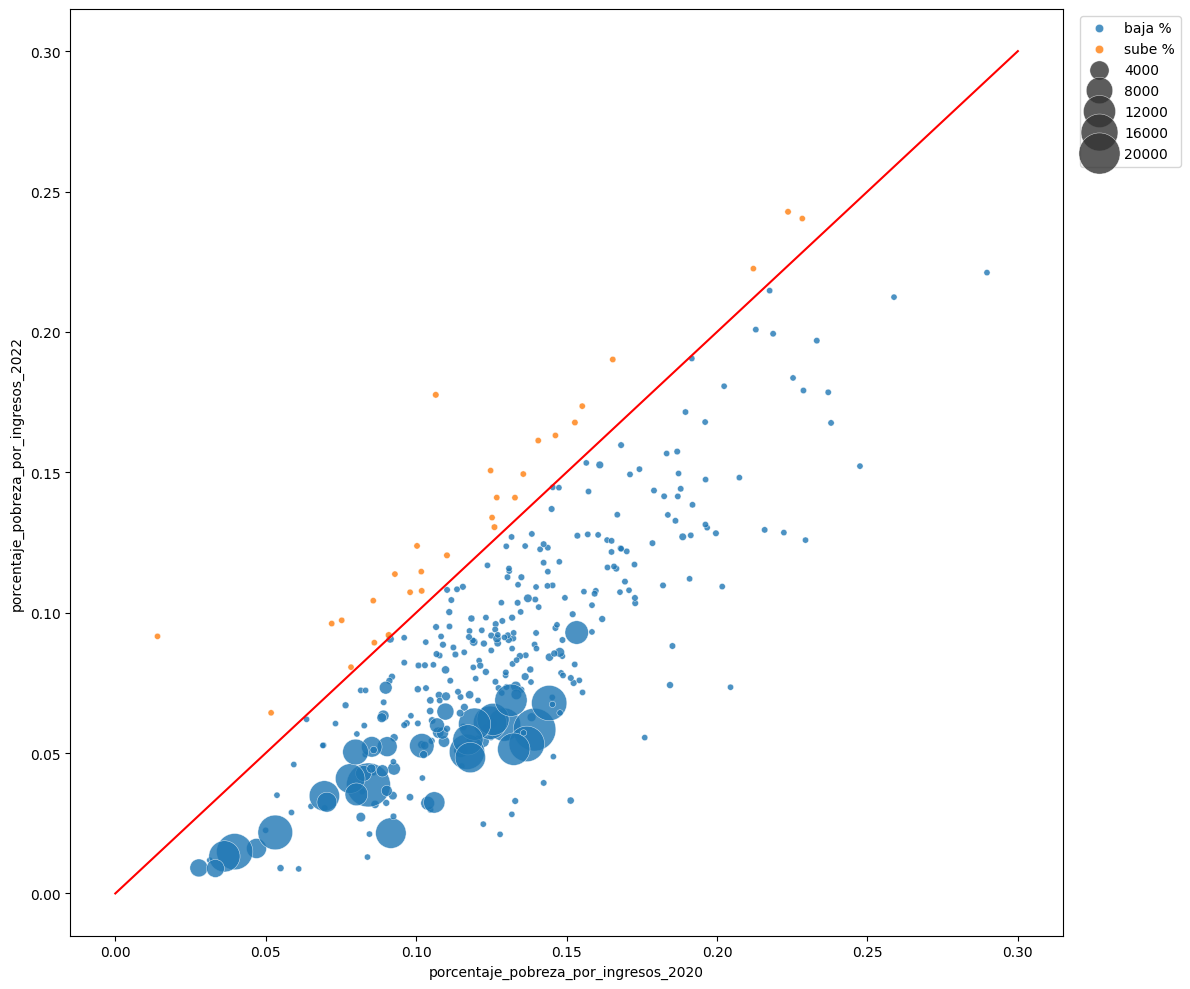

In [21]:
fig, ax = plt.subplots(1, figsize=(12,10))

sns.scatterplot(data=df_merge_3, x='porcentaje_pobreza_por_ingresos_2020', y='porcentaje_pobreza_por_ingresos_2022',
                alpha=0.8, ax=ax, size='densidad_pob_2022', sizes=(20, 1000), marker='o',
                hue=['sube %' if i<0 else 'baja %' for i in df_merge_3['diff_porcentaje_pobreza_por_ingresos']])
ax.plot([0, 0.3], [0, 0.3], color='r')

ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

Solo par efectos de visualización, podría ser más interesante representar el scatter en coordenadas polares, donde la diferencia de porcentaje de pobreza por ingreso sea la componente angular y el valor 0% limite si mejoró (gris) o empeoró (rojo) la pobreza.

Por otro lado el eje radial, representado por el porcentaje de pobreza por ingreso del 2022, muestra a condición actual de pobreza por comuna.

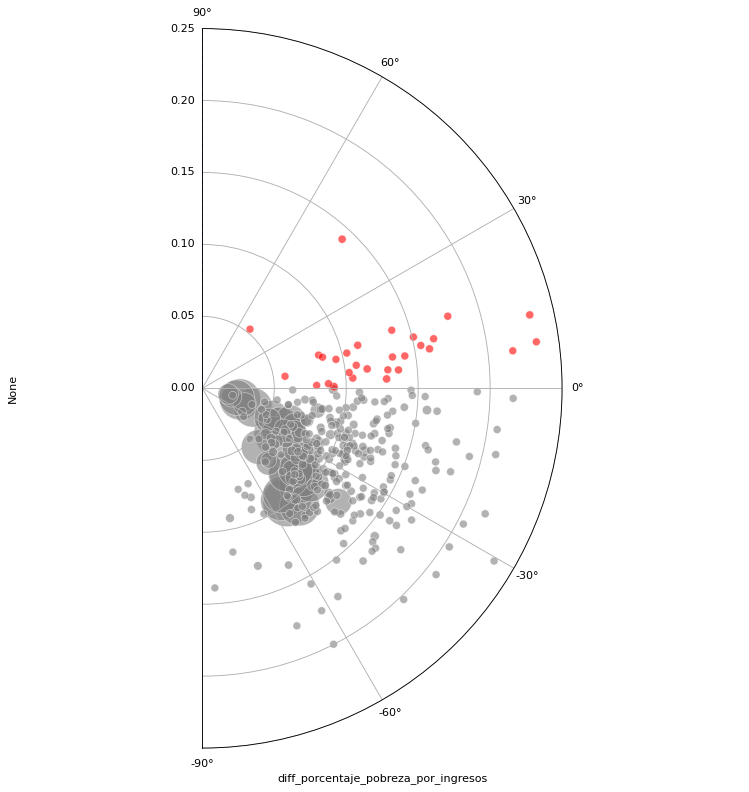

In [22]:
# Las comunas con mayor poblacion (y con mayor densidad de poblacion) disminuyeron su porcentaje de pobreza por ingreso
fig, ax = plt.subplots(1, figsize=(12,10), subplot_kw={'projection': 'polar'}, dpi=80)

df_merge_3_polar = df_merge_3.copy()
df_merge_3_polar = df_merge_3_polar.sort_values('densidad_pob_2022', ascending=False)
sns.scatterplot(x=-df_merge_3_polar['diff_porcentaje_pobreza_por_ingresos']*0.48*np.pi/df_merge_3['diff_porcentaje_pobreza_por_ingresos'].abs().max(),
                y=(df_merge_3_polar['porcentaje_pobreza_por_ingresos_2022'] + df_merge_3_polar['porcentaje_pobreza_por_ingresos_2020'])*0.5, 
                alpha=0.6, ax=ax, 
                size=df_merge_3_polar['densidad_pob_2022'], 
                sizes=(50, 2000), marker='o',
                hue=['r' if i>0 else 'gray' for i in df_merge_3_polar['diff_porcentaje_pobreza_por_ingresos']],
                palette=['gray', 'r'], legend=False)
ax.plot([0, 0.5*np.pi], [0, 0.3], color='b', linestyle='--')
ax.set_thetamin(90)    # Ángulo mínimo en grados
ax.set_thetamax(-90)  # Ángulo máximo en grados
ax.set_rmax(0.25)

plt.tight_layout()
plt.show()

Otro punto relevante es si existe alguna relación entre la distribución geográfica y el aumento o disminución de pobreza. Para esto graficamos las comunas a lo largo de Chile con su diferencia de pobreza 2022-2020.

No se observa alguna relación relevante en la distribución geográfica, solo 2 ciudades en el sur cun mucho aumento de pobreza.

En cualquier caso, este grafico es útil para representar qcomo referencia de que no hay algún patrón geográfico directo.

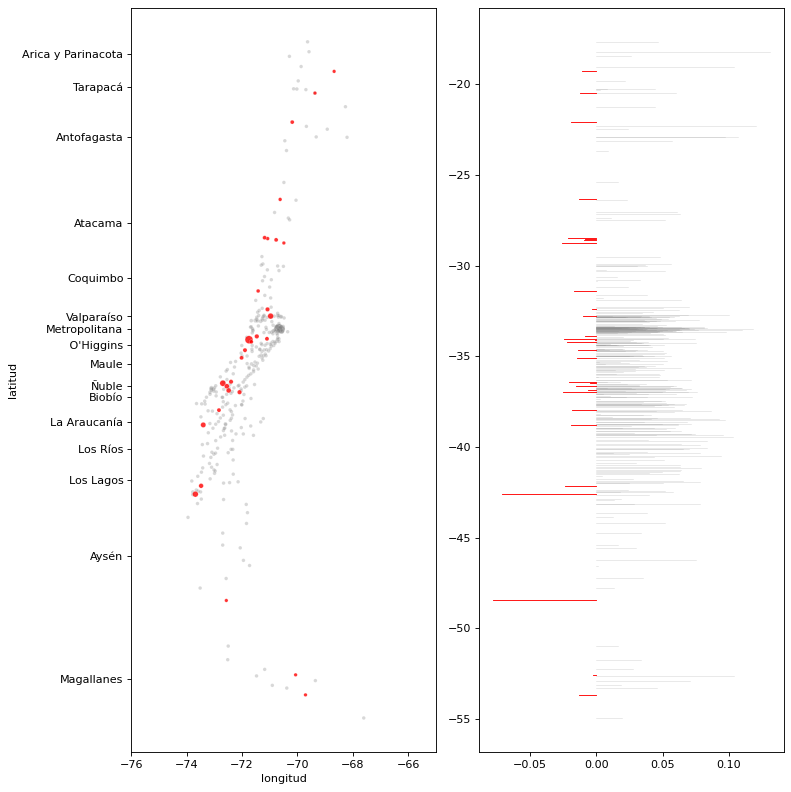

In [23]:
regiones_sort = {'Arica y Parinacota': 1, 'Tarapacá': 2, 'Antofagasta': 3, 'Atacama': 4, 'Coquimbo': 5, 'Valparaíso': 6, 'Metropolitana': 7, " O'Higgins": 8, 
                'Maule': 9, 'Ñuble': 10, 'Biobío': 11, 'La Araucanía': 12, 'Los Ríos': 13, 'Los Lagos': 14, 'Aysén': 15, 'Magallanes': 16}

df_merge_3['num_region'] = [17-regiones_sort[r] for r in df_merge_3.region]

# La subida o baja en el indice no parece tener alguna relación con la distribución geográfica
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10), dpi=80)
diamond_marker = "o"#((0, -0.8), (1.5, 0), (0, 0.8), (-1.5, 0))
df_m_3 = df_merge_3[df_merge_3['diff_porcentaje_pobreza_por_ingresos']>=0]
for d in df_m_3.itertuples():
    sns.lineplot(x=[0, d.diff_porcentaje_pobreza_por_ingresos],
                    y=[d.latitud, d.latitud], linewidth=0.5,
                    color='gray', alpha=0.3, ax=ax2)
sns.scatterplot(data=df_m_3, 
            x='longitud', y='latitud', size='densidad_pob_2022', sizes=(10, 50), marker=diamond_marker, alpha=0.3, ax=ax1, c='gray', legend=False)


df_m_3 = df_merge_3[df_merge_3['diff_porcentaje_pobreza_por_ingresos']<0]
for d in df_m_3.itertuples():
    sns.lineplot(x=[0, d.diff_porcentaje_pobreza_por_ingresos],
                    y=[d.latitud, d.latitud], linewidth=0.8,
                    color='r', alpha=1.0, ax=ax2)
sns.scatterplot(data=df_m_3, 
            x='longitud', y='latitud', size='densidad_pob_2022', sizes=(10, 50), marker=diamond_marker, alpha=0.8, ax=ax1, c='r', legend=False)

sns.lineplot(x=[0, 0],
            y=[df_merge_3.latitud.min(), df_merge_3.latitud.max()], linewidth=0.5,
                    color='gray', alpha=0.5, ax=ax1)
ax1.set_yticks(df_merge_3.groupby('num_region')['latitud'].mean(numeric_only=True).sort_values(ascending=False))
ax1.set_yticklabels([r for r in regiones_sort.keys()])
ax1.set_xlim([-76,-65])

plt.tight_layout()
plt.show()

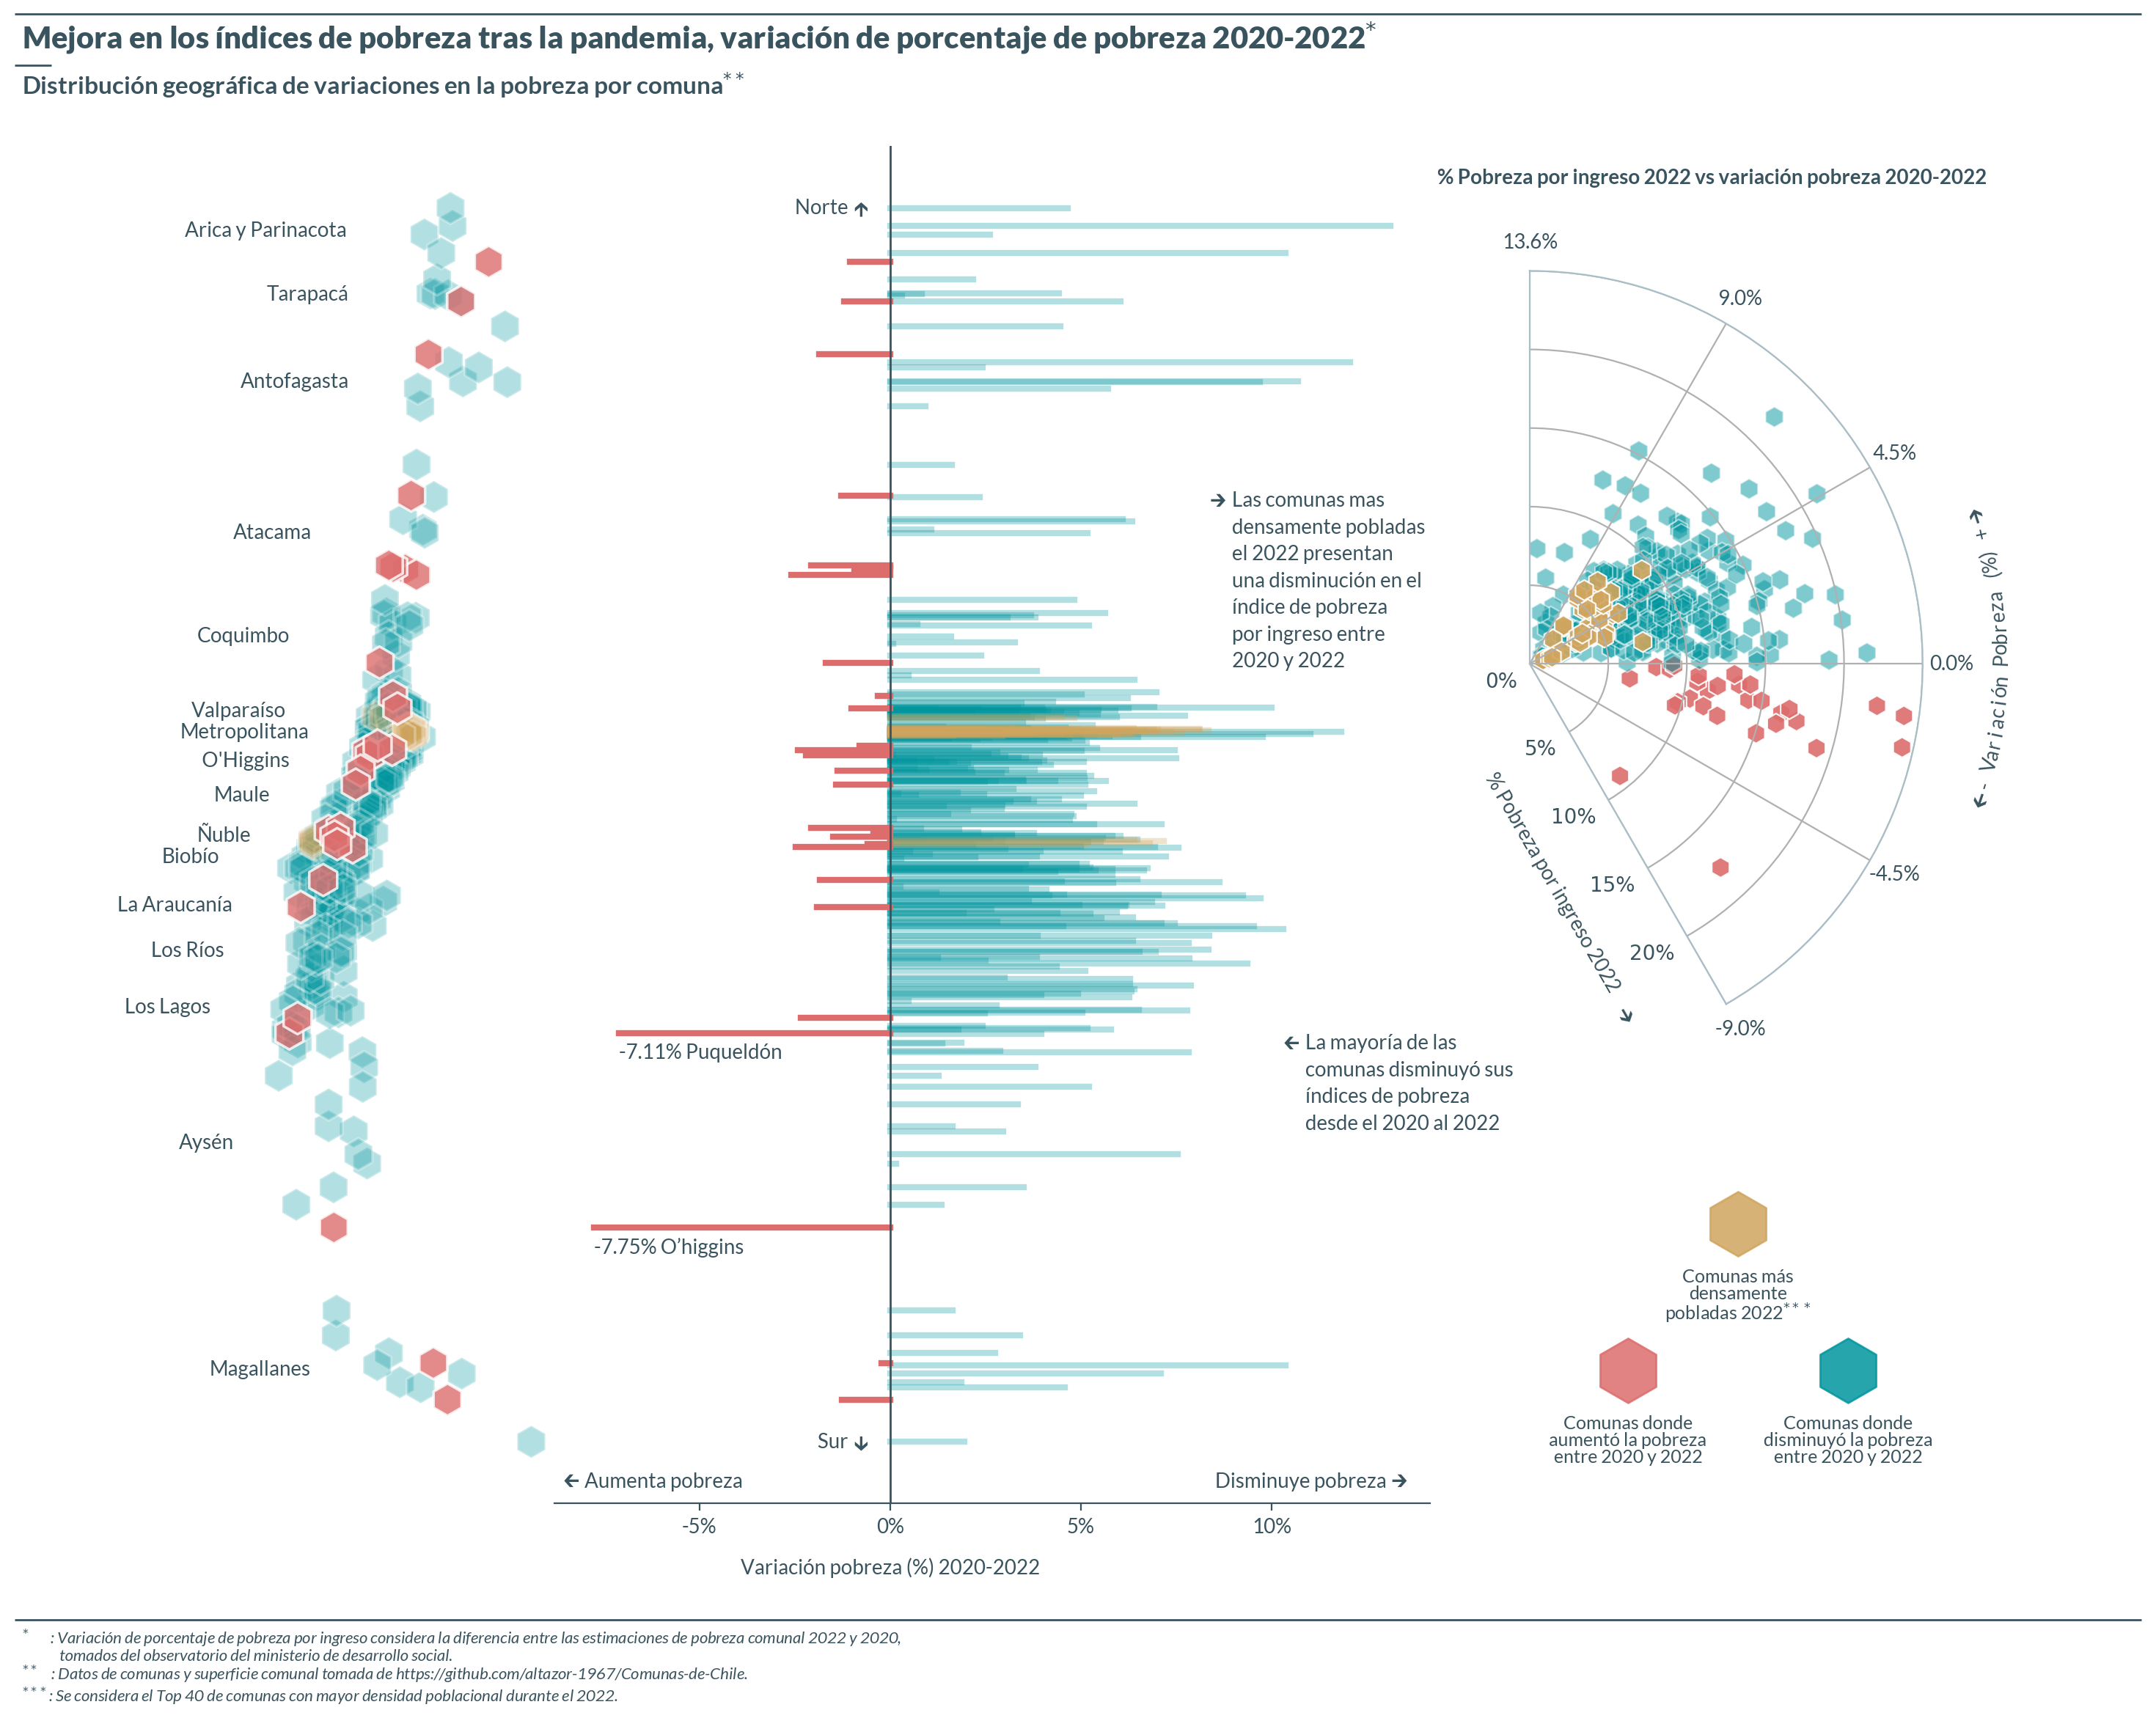

In [24]:
# Funciones
############################################################################################

def polarScatter(df, fig, pos=[0.6, 0.85, 0.5, 0.5]):
    polar_ax = fig.add_axes(pos, projection='polar')
    n_adj = 0.48
    df_merge_3_polar = df.copy()
    df_merge_3_polar = df_merge_3_polar.sort_values('densidad_pob_2022', ascending=True)

    beta_ = n_adj*np.pi/df_merge_3_polar['diff_porcentaje_pobreza_por_ingresos'].abs().max()
    sns.scatterplot(x=df_merge_3_polar['diff_porcentaje_pobreza_por_ingresos']*beta_,
                    y=df_merge_3_polar['porcentaje_pobreza_por_ingresos_2022'], 
                    alpha=[0.9 if i.diff_porcentaje_pobreza_por_ingresos<0 else 0.5 if i.densidad_pob_2022<1250 else 0.9 for i in df_merge_3_polar.itertuples()], 
                    ax=polar_ax, 
                    size=[100 if i.diff_porcentaje_pobreza_por_ingresos<0 else 100 if i.densidad_pob_2022<1250 else 400 for i in df_merge_3_polar.itertuples()],#df_merge_3_polar['densidad_pob_2022'], 
                    sizes=(100, 100), 
                    marker='h',
                    hue=['r' if i.diff_porcentaje_pobreza_por_ingresos<0 else 'gray' if i.densidad_pob_2022<1250 else 'blue' for i in df_merge_3_polar.itertuples()],
                    palette=[colorGreen, colorSalmon, colorYellow], legend=False)
    polar_ax.set_thetamin(-60)    # Ángulo mínimo en grados
    polar_ax.set_thetamax(90)  # Ángulo máximo en grados
    polar_ax.set_rmax(0.25)
    for spine in polar_ax.spines.values():
        spine.set_color(colorGray)
    polar_ax.set_ylabel("")
    polar_ax.set_xlabel("")
    polar_ax.set_yticklabels([str(int(100*y))+'%' for y in polar_ax.get_yticks()][:-1], fontproperties=prop_latoR)
    polar_ax.set_xticklabels([str(int(1000*x/beta_)/10)+'%' for x in polar_ax.get_xticks()], fontproperties=prop_latoR)
    polar_ax.xaxis.label.set_color(colorGrayText)
    polar_ax.tick_params(axis='x', colors=colorGrayText)
    polar_ax.tick_params(axis='y', colors=colorGrayText)

    # Especificar el texto y sus propiedades
    text_ = "- Variación Pobreza (%) +"
    radius = 0.3  # Radio donde el texto se ubicará
    angle_start = -3.5  # Ángulo inicial del arco (en grados, -90 para empezar en la parte inferior del arco)

    # Calcular la posición angular de cada letra
    angle_per_char = 1.3  # Ángulo entre cada letra, ajusta este valor para espaciar las letras
    angles = np.linspace(angle_start, angle_start + angle_per_char * (len(text_) - 1), len(text_))

    # Dibujar el texto en el arco
    for i, (char, angle) in enumerate(zip(text_, angles)):
        # Convertir el ángulo a radianes para que Matplotlib lo entienda
        angle_rad = np.deg2rad(angle)
        # Agregar el texto en la posición correspondiente
        polar_ax.text(angle_rad-0.2, radius, char, rotation=angle+75, rotation_mode='anchor',
                ha='center', va='center', fontsize=10, color=colorGrayText, fontproperties=prop_latoR)
    polar_ax.text(angle_rad-0.16, radius, "🡲", ha='center', va='center', rotation=90+18, 
            fontsize=10, weight=900, rotation_mode='anchor',
            color=colorGrayText, fontproperties=prop_noto2)
    polar_ax.text(angle_rad-0.775, radius, "🡰", ha='center', va='center', rotation=90-19, 
            fontsize=10, weight=900, rotation_mode='anchor',
            color=colorGrayText, fontproperties=prop_noto2)

def drawHex(fig, size, pos, color, alpha):
    hex_ax = fig.add_axes(pos)
    hex_ax.scatter(x=0, y=0, color=color, s=size, marker='h', alpha=alpha)
    hex_ax.set_aspect('equal', adjustable='box')
    hex_ax.set_axis_off()


# Grafico
############################################################################################
# La subida o baja en el indice no parece tener alguna relación con la distribución geográfica
fig = plt.figure(figsize=(10,10), dpi=200) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])  # El primer subplot será el doble de ancho que el segundo
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

n_size=250
diamond_marker = "h"#((0, -0.8), (1.5, 0), (0, 0.8), (-1.5, 0))

df_m_3 = df_merge_3[(df_merge_3['diff_porcentaje_pobreza_por_ingresos']>=0)&(df_merge_3['densidad_pob_2022']<1250)]
for d in df_m_3.itertuples():
    sns.lineplot(x=[0, d.diff_porcentaje_pobreza_por_ingresos],
                    y=[d.latitud, d.latitud], linewidth=3,
                    color=colorGreen, alpha=0.3, ax=ax2, zorder=1)
sns.scatterplot(data=df_m_3, 
            x='longitud', y='latitud', size='poblacion', sizes=(n_size, n_size), marker=diamond_marker, alpha=0.3, ax=ax1, c=colorGreen, legend=False, zorder=2)

df_m_3 = df_merge_3[(df_merge_3['diff_porcentaje_pobreza_por_ingresos']>=0)&(df_merge_3['densidad_pob_2022']>=1250)]
for d in df_m_3.itertuples():
    sns.lineplot(x=[0, d.diff_porcentaje_pobreza_por_ingresos],
                    y=[d.latitud, d.latitud], linewidth=3,
                    color=colorYellow, alpha=0.3, ax=ax2, zorder=1)
sns.scatterplot(data=df_m_3, 
            x='longitud', y='latitud', size='poblacion', sizes=(n_size, n_size), marker=diamond_marker, alpha=0.3, ax=ax1, c=colorYellow, legend=False, zorder=2)

df_m_3 = df_merge_3[df_merge_3['diff_porcentaje_pobreza_por_ingresos']<0]
for d in df_m_3.itertuples():
    sns.lineplot(x=[0, d.diff_porcentaje_pobreza_por_ingresos],
                    y=[d.latitud, d.latitud], linewidth=3,
                    color=colorSalmon, alpha=1.0, ax=ax2, zorder=1)
sns.scatterplot(data=df_m_3, 
            x='longitud', y='latitud', size='poblacion', sizes=(n_size, n_size), marker=diamond_marker, alpha=0.8, ax=ax1, c=colorSalmon, legend=False, zorder=2)

ax2.axvline(x=0, color=colorGrayText, linewidth=1, label='', zorder=2)

for d in df_merge_3.sort_values('latitud', ascending=False).groupby('region', as_index=False).median(numeric_only=True).sort_values('latitud', ascending=False).itertuples():
    ax1.text(d.longitud - 2.5, d.latitud, d.region, ha='right', va='center', color=colorGrayText, fontproperties=prop_latoR)

ax1.set_yticks([])
ax1.set_xlim([-76,-65])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.tick_params(axis='both', which='both', length=0)

pos2 = ax2.get_position()
ax2.set_position([pos2.x0+0.07, pos2.y0, pos2.width, pos2.height])
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.patch.set_facecolor('none')
ax2.set_yticks([])
ax2.set_xticklabels([str(int(100*x))+'%' for x in ax2.get_xticks()], fontproperties=prop_latoR)
ax2.spines['bottom'].set_color(colorGrayText)
ax2.tick_params(axis='x', colors=colorGrayText)
ax2.xaxis.label.set_color(colorGrayText)

ax2.text(0, df_merge_3.latitud.min()-3.5, "Variación pobreza (%) 2020-2022", ha='center', va='top', 
            fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_latoR, rotation=0)
ax2.text(0.13, df_merge_3.latitud.min()-1.2, "Disminuye pobreza", ha='right', va='center', 
            fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_latoR, rotation=0)
ax2.text(0.13, df_merge_3.latitud.min()-1.2, " 🡲", ha='left', va='center', 
            fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_noto2, rotation=0)
ax2.text(-0.08, df_merge_3.latitud.min()-1.2, "Aumenta pobreza", ha='left', va='center', 
            fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_latoR, rotation=0)
ax2.text(-0.08, df_merge_3.latitud.min()-1.2, "🡰 ", ha='right', va='center', 
            fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_noto2, rotation=0)
ax2.text(-0.01, df_merge_3.latitud.min(), "Sur ", ha='right', va='center', 
            fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_latoR, rotation=0)
ax2.text(-0.01, df_merge_3.latitud.min(), "🡰", ha='left', va='center', 
            fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_noto2, rotation=90)
ax2.text(-0.01, df_merge_3.latitud.max(), "Norte ", ha='right', va='center', 
            fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_latoR, rotation=0)
ax2.text(-0.01, df_merge_3.latitud.max(), "🡲", ha='left', va='center', 
            fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_noto2, rotation=90)

df_oh = df_merge_3[df_merge_3.comuna_x=='O’higgins']
ax2.text(df_oh.diff_porcentaje_pobreza_por_ingresos.values[0], 
        df_oh.latitud-0.3,
        str(np.round(df_oh.diff_porcentaje_pobreza_por_ingresos.values[0]*100,2)) + '% ' + df_oh.comuna_x.values[0], 
        ha='left', va='top', fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_latoR, rotation=0)

df_pu = df_merge_3[df_merge_3.comuna_x=='Puqueldón']
ax2.text(df_pu.diff_porcentaje_pobreza_por_ingresos.values[0], 
        df_pu.latitud-0.3,
        str(np.round(df_pu.diff_porcentaje_pobreza_por_ingresos.values[0]*100,2)) + '% ' + df_pu.comuna_x.values[0], 
        ha='left', va='top', fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_latoR, rotation=0)

# Anotaciones
fig.text(0.83, 0.38, "La mayoría de las\ncomunas disminuyó sus\níndices de pobreza\ndesde el 2020 al 2022", ha='left', va='top', 
            fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_latoR, rotation=0, linespacing=1.5)
fig.text(0.83, 0.38, "🡰 ", ha='right', va='top', 
            fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_noto2, rotation=0, linespacing=1.5)

fig.text(0.78, 0.75, "Las comunas mas\ndensamente pobladas\nel 2022 presentan\nuna disminución en el\níndice de pobreza\npor ingreso entre\n2020 y 2022", ha='left', va='top', 
            fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_latoR, rotation=0, linespacing=1.5)
fig.text(0.78, 0.75, "🡲 ", ha='right', va='top', 
            fontsize=10, weight=900, color=colorGrayText, fontproperties=prop_noto2, rotation=0, linespacing=1.5)

# Polar Scatter
x_=0.87
y_=0.4
polarScatter(df_merge_3.sort_values('densidad_pob_2022', ascending=False), fig, pos=[x_, y_, 0.5, 0.5])

fig.text(x_+0.08, y_+0.16, "% Pobreza por ingreso 2022", ha='left', va='top', 
            fontsize=10, weight=900, 
            color=colorGrayText, fontproperties=prop_latoR, rotation=-60)
fig.text(x_+0.168, y_, "🡲", ha='left', va='top', 
            fontsize=10, weight=900, 
            color=colorGrayText, fontproperties=prop_noto2, rotation=-60)

fig.text(x_+0.05, 0.97, "% Pobreza por ingreso 2022 vs variación pobreza 2020-2022", ha='left', va='top', 
            fontsize=10, weight=900, 
            color=colorGrayText, fontproperties=prop_latoB, rotation=0)

# Titulo
pos_y_ = -0.025
posx_line_title = [-0.05, 1.4+0]
posy_line_title = [1.1+pos_y_, 1.1+pos_y_]
lw_line_title = 1
pos_x0_title = -0.045
pos_y0_title = 1.097+pos_y_
fig.add_artist(
    lines.Line2D(posx_line_title, posy_line_title, lw=1, 
                color=colorGrayText, solid_capstyle="butt", 
                transform=fig.transFigure ))
fig.text(pos_x0_title, pos_y0_title, "Mejora en los índices de pobreza tras la pandemia, variación de porcentaje de pobreza 2020-2022$^{*}$",
        ha='left', va='top', fontsize=15, weight=700, 
        color=colorGrayText, fontproperties=prop_latoBlack, linespacing=1)

pos_y_2 = -0.035
posx_line_title = [-0.05, -0.025]
posy_line_title = [1.1+pos_y_+pos_y_2, 1.1+pos_y_+pos_y_2]
lw_line_title = 1
pos_x0_title = -0.045
pos_y0_title = 1.097+pos_y_+pos_y_2
fig.add_artist(
    lines.Line2D(posx_line_title, posy_line_title, lw=1, 
                color=colorGrayText, solid_capstyle="butt", 
                transform=fig.transFigure ))
fig.text(pos_x0_title, pos_y0_title, "Distribución geográfica de variaciones en la pobreza por comuna$^{**}$",
        ha='left', va='top', fontsize=12, weight=700, 
        color=colorGrayText, fontproperties=prop_latoB, linespacing=1)

# Simbologia
x_i_=0.
drawHex(fig, 1000, [0.9+x_i_,0.,0.3,0.3], colorSalmon, 0.85)
fig.text(1.0+0.05, 0.12, "Comunas donde\naumentó la pobreza\nentre 2020 y 2022",
        ha='center', va='top', fontsize=9, weight=700, 
        color=colorGrayText, fontproperties=prop_latoR, linespacing=1)
drawHex(fig, 1000, [0.9+x_i_+.15,0.,0.3,0.3], colorGreen, 0.85)
fig.text(1.15+0.05, 0.12, "Comunas donde\ndisminuyó la pobreza\nentre 2020 y 2022",
        ha='center', va='top', fontsize=9, weight=700, 
        color=colorGrayText, fontproperties=prop_latoR, linespacing=1)
drawHex(fig, 1000, [0.9+x_i_+.075,0.1,0.3,0.3], colorYellow, 0.85)
fig.text(1.075+0.05, 0.22, "Comunas más\ndensamente\npobladas 2022$^{***}$",
        ha='center', va='top', fontsize=9, weight=700, 
        color=colorGrayText, fontproperties=prop_latoR, linespacing=1)

# pie de pagina
pos_y_ = 0.08
posx_line_title = [-0.05, 1.4+0]
posy_line_title = [-0.1+pos_y_, -0.1+pos_y_]
lw_line_title = 1
pos_x0_title = -0.045
pos_y0_title = 0.025-0.05
fig.add_artist(
    lines.Line2D(posx_line_title, posy_line_title, lw=1, 
                color=colorGrayText, solid_capstyle="butt", 
                transform=fig.transFigure ))
fig.text(pos_x0_title, pos_y0_title, 
        "$^{*}$       : Variación de porcentaje de pobreza por ingreso considera la diferencia entre las estimaciones de pobreza comunal 2022 y 2020,\n"+
        "            tomados del observatorio del ministerio de desarrollo social.\n"+
        "$^{**}$    : Datos de comunas y superficie comunal tomada de https://github.com/altazor-1967/Comunas-de-Chile.\n"
        "$^{***}$: Se considera el Top 40 de comunas con mayor densidad poblacional durante el 2022.",
        ha='left', va='top', fontsize=8, weight=700, 
        color=colorGrayText, fontproperties=prop_latoI, linespacing=1)

plt.tight_layout()
plt.show()